In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from lifelines import KaplanMeierFitter
from lifelines import WeibullAFTFitter, CoxPHFitter
from scipy.stats import chi2
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
from functools import partial
import matplotlib.colors
from lifelines.statistics import logrank_test
from functools import partial
from scipy.stats import pearsonr
import os

In [2]:
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"

BIRTH_FIELD = "34-0.0"
SEX_FIELD = "31-0.0" # 0 female, 1 male
CHOLESTEROL_FIELD = "30690-0.0" 
DIABETES_FIELD = "2443-0.0"
CRP_FIELD = "30710-0.0"
HDL_FIELD = "30760-0.0"
SYSTOLIC_BP_FIELD = "4080-0.0"
BMI_FIELD = "21001-0.0"
genetic_PCs = ["22009-0.%d" % i for i in range(1,11)]
SMOKING_FIELD = "20161-0.0"

basics_X_cols = [SMOKING_FIELD] + genetic_PCs # ,BMI_FIELD,DIABETES_FIELD,CHOLESTEROL_FIELD

In [3]:
UKB = pd.read_hdf("%s/UKB.hdf" % export_folder)

In [4]:
UKB.loc[UKB[SMOKING_FIELD].isnull(),SMOKING_FIELD] = 0.
UKB.loc[UKB[DIABETES_FIELD].isnull(),DIABETES_FIELD] = 0.
UKB.loc[UKB[DIABETES_FIELD] < 0,DIABETES_FIELD] = 0.
UKB[DIABETES_FIELD] = UKB[DIABETES_FIELD].astype(int)
UKB.loc[UKB[BMI_FIELD].isnull(),BMI_FIELD] = UKB.loc[~UKB[BMI_FIELD].isnull(),BMI_FIELD].mean()
UKB.loc[UKB[CHOLESTEROL_FIELD].isnull(),CHOLESTEROL_FIELD] = UKB.loc[~UKB[CHOLESTEROL_FIELD].isnull(),CHOLESTEROL_FIELD].mean()

In [5]:
UKB[DIABETES_FIELD].value_counts()

0    365593
1     18466
Name: 2443-0.0, dtype: int64

In [6]:
UKB[basics_X_cols].head(3)

,20161-0.0,22009-0.1,22009-0.2,22009-0.3,22009-0.4,22009-0.5,22009-0.6,22009-0.7,22009-0.8,22009-0.9,22009-0.10
eid,,,,,,,,,,,
1000011,0.0,-13.4848,1.06092,-3.047350,2.22877,-6.06503,-3.956770,0.877139,-0.901110,-1.835710,-0.401581
1000026,0.0,-13.2959,4.07063,0.425932,4.78868,1.00465,-0.544458,-2.408010,-1.404980,1.165280,0.278346
1000032,0.0,-15.4969,5.15194,-2.708700,4.22973,5.24573,-1.585010,2.513620,-0.968024,-0.302836,-1.710030


In [7]:
UKB.sample(3)

,31-0.0,34-0.0,845-0.0,2139-0.0,2217-0.0,2443-0.0,2714-0.0,2754-0.0,2764-0.0,2794-0.0,...,132588-0.0,132590-0.0,132592-0.0,132594-0.0,132596-0.0,132598-0.0,132600-0.0,132602-0.0,132604-0.0,AGE
eid,,,,,,,,,,,,,,,,,,,,,
5632764,1.0,1950-01-01,NaN,22.0,25.0,0,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,69.0
5041047,1.0,1944-01-01,15.0,22.0,-1.0,0,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,75.0
3422482,1.0,1939-01-01,15.0,16.0,50.0,1,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,80.0


In [8]:
betas = pd.read_hdf("%s/UKB_causal_SNPS_genotypes/betas.hdf" % export_folder,key="scores")

In [9]:
betas

SNP,rs12566888,rs1434282,rs41315846,rs13412535,rs78909033,rs1354034,rs13067286,rs76445378,rs922140,rs3819288,...,rs61751937,rs10886430,rs7123827,rs11553699,rs61978213,rs59001897,rs8057254,rs12445050,rs11078475,rs1654425
ADP_pred,0.1248,0.069544,0.049249,0.057557,0.069758,0.074894,-0.047616,0.16771,-0.068151,0.083528,...,-0.169112,-0.068886,-0.043878,-0.13446,-0.124011,-0.055161,-0.055509,-0.107511,-0.045222,-0.091918
ALLELE1,G,C,T,G,G,T,G,C,A,T,...,G,A,A,A,G,T,T,C,T,T
COUNTED,T,T,C,A,A,C,A,T,G,C,...,C,G,C,G,A,A,A,T,C,C


In [10]:
scores = pd.read_hdf("%s/scores_table.hdf" % export_folder,key="scores")

In [11]:
scores.sample(3)

,INTERVAL_score,ADP_score,best_pval_score,best_pval_score_homogenous,PLT_score,MPV_score,PCT_score,PDW_score
IID,,,,,,,,
1678114,-0.675680,-0.482274,1.480698,0.060629,0.010456,-0.027186,-0.006231,-0.004938
3545598,-0.332359,0.009625,2.397067,0.225117,0.014338,-0.021920,0.006759,-0.001607
1365267,-0.479456,-0.456128,1.226940,0.090142,0.006242,-0.025674,-0.008270,-0.015118


In [12]:
X = pd.merge(UKB, scores, left_index=True,right_index=True,how="inner")

In [13]:
X[CRP_FIELD] = X[CRP_FIELD].fillna(X[CRP_FIELD].mean())
X[SYSTOLIC_BP_FIELD] = X[SYSTOLIC_BP_FIELD].fillna(X[SYSTOLIC_BP_FIELD].mean())

In [14]:
assert X[basics_X_cols].isnull().sum(axis=0).sum() == 0

In [15]:
# Done loading X

In [16]:
#all_ICD10_events = pd.read_csv("%s/ICD10_events.csv" % export_folder,index_col=0)
#all_ICD10_events["Date"] = pd.to_datetime(all_ICD10_events.Date)
#print(all_ICD10_events.shape)

In [17]:
X.shape

(384059, 1645)

In [18]:
ICD10_sec_desc = pd.read_csv("%s/coding19.tsv" % export_folder, sep="\t").set_index("coding")["meaning"].to_dict()

In [19]:
coag_related_codes = ["I21","I25","I26","I80","H40"]
ICD10_sec_desc["meta_coag"] = "Coag ICD10 code (DVT, CAD, PE, MI, glaucoma)"
for code in coag_related_codes:
    print(ICD10_sec_desc[code])

I21 Acute myocardial infarction
I25 Chronic ischaemic heart disease
I26 Pulmonary embolism
I80 Phlebitis and thrombophlebitis
H40 Glaucoma


In [20]:
all_ICD10_events = pd.read_csv("/home/hv270/rds/rds-who1000-cbrc/phenotypes.csv")
all_ICD10_events = all_ICD10_events.loc[all_ICD10_events.pheno_type == "ICD10-UKB"]
all_ICD10_events = all_ICD10_events.rename(columns={"pheno_id":"code","age":"AGE_AT_EVENT","sample_id":"ID"})
all_ICD10_events = all_ICD10_events[["code","AGE_AT_EVENT","ID"]]

print(all_ICD10_events.shape)

all_ICD10_events_shortcodes = all_ICD10_events.copy()
all_ICD10_events_shortcodes["code"] = all_ICD10_events_shortcodes["code"].str.split(".",expand=True)[0]
all_ICD10_events_shortcodes = all_ICD10_events_shortcodes.loc[~all_ICD10_events_shortcodes.code.isin(all_ICD10_events.code.unique().tolist())]
print(all_ICD10_events.code.nunique())
print(all_ICD10_events_shortcodes.code.nunique())
all_ICD10_events = pd.concat([all_ICD10_events,all_ICD10_events_shortcodes],axis=0)
print(all_ICD10_events.code.nunique())

print(all_ICD10_events.shape)

/home/hv270/platelets/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(5989813, 3)
12222
1655
13877
(11008703, 3)


In [21]:
diabetes_events = all_ICD10_events.loc[all_ICD10_events.code.str.contains("E08") |\
                                       all_ICD10_events.code.str.contains("E09") |\
                                       all_ICD10_events.code.str.contains("E10") |\
                                       all_ICD10_events.code.str.contains("E11") |\
                                       all_ICD10_events.code.str.contains("E12") |\
                                       all_ICD10_events.code.str.contains("E13")]

In [22]:
first_diabete = diabetes_events.groupby("ID")[["AGE_AT_EVENT"]].min().reset_index()\
    .rename(columns={"AGE_AT_EVENT":"AGE_AT_DIABETES"})

In [23]:
diabetes_IDs = first_diabete.ID.tolist()
diabetes_codes = diabetes_events.code.unique().tolist()

In [24]:
X = pd.merge(X,first_diabete,left_index=True,right_on="ID",how="left").set_index("ID")
X["AGE_AT_DIABETES"].fillna(np.inf,inplace=True)

In [25]:
meta_coag_events = all_ICD10_events.loc[all_ICD10_events.code.isin(coag_related_codes)].groupby("ID").agg({"AGE_AT_EVENT":"min"}).reset_index()
meta_coag_events["code"] = "meta_coag"
meta_coag_events = meta_coag_events[["code","AGE_AT_EVENT","ID"]]
all_ICD10_events = pd.concat([all_ICD10_events,meta_coag_events],axis=0)
meta_coag_events.head()

,code,AGE_AT_EVENT,ID
0,meta_coag,62.0,1000044
1,meta_coag,60.0,1000150
2,meta_coag,74.0,1000195
3,meta_coag,65.0,1000252
4,meta_coag,58.0,1000289


In [26]:
X["SMOKING_BOOL"] = (X[SMOKING_FIELD] >= 3)*1

In [27]:
X["SMOKING_RATE"] = np.clip((X[SMOKING_FIELD] - 15)/X["AGE"],a_min=0,a_max=2)

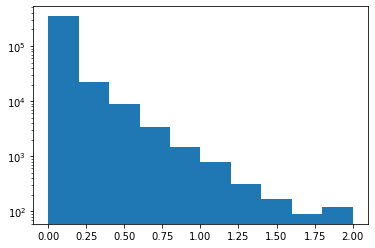

In [28]:
plt.hist(X["SMOKING_RATE"])
plt.yscale("log")

In [29]:
X[CRP_FIELD] = np.clip(X[CRP_FIELD],a_min=0,a_max=10)

In [30]:
X["AGE_int"] = np.floor(X["AGE"])

(array([3.24000e+02, 4.49850e+04, 1.47161e+05, 1.00747e+05, 3.45850e+04,
        7.62200e+03, 1.25400e+03, 2.38000e+02, 3.00000e+01, 1.00000e+01]),
 array([0.219 , 0.6372, 1.0554, 1.4736, 1.8918, 2.31  , 2.7282, 3.1464,
        3.5646, 3.9828, 4.401 ]),
 <a list of 10 Patch objects>)

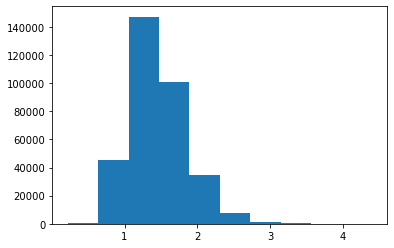

In [31]:
plt.hist(X[HDL_FIELD])

In [32]:
# Doing the PH test, we found that smoking and cholesterol are age-related and should thus be used more as strata
X["SMOKING_RATE_bin"] = pd.cut(X["SMOKING_RATE"],bins=[-0.001,0.0001,.5,2.01],labels=False)
X["CHOLESTEROL_bin"] = pd.qcut(X[CHOLESTEROL_FIELD],4,labels=False)
X["HDL_bin"] = pd.qcut(X[HDL_FIELD],3,labels=False)
X["CRP_bin"] = pd.qcut(X[CRP_FIELD],4,labels=False)
X["SYSTOLIC_BP_bin"] = pd.qcut(X[SYSTOLIC_BP_FIELD],3,labels=False)

In [33]:
sysmex_covars = ["MPV_score","PLT_score","PDW_score","PCT_score"]  # ,"IPF_score"
pheno_cols_to_norm = [c for c in list(scores.columns) if c not in sysmex_covars]
cols_to_normalize = sysmex_covars + pheno_cols_to_norm #+ [SMOKING_FIELD]
X[cols_to_normalize] -= X[cols_to_normalize].mean(axis=0)
X[cols_to_normalize] /= X[cols_to_normalize].std(axis=0)

In [34]:
# Create decomposition of sysmex covariates so that they don't correlate
pc_covars_cols = ["sysmex_PC_%d" % i for i in range(len(sysmex_covars))]
pca = PCA()
X[pc_covars_cols] = pca.fit_transform(X[sysmex_covars])
X[pc_covars_cols] -= X[pc_covars_cols].mean(axis=0)
X[pc_covars_cols] /= X[pc_covars_cols].std(axis=0)

In [35]:
all_codes = all_ICD10_events.code.unique().tolist()

In [36]:
min_n_cases = 1000

In [37]:
basics_ = {"none":[],
           #"sysmex":pc_covars_cols[:3],
           #"environmental":[BMI_FIELD],
          }
           #"all":pc_covars_cols[:3] + ["SMOKING_RATE",BMI_FIELD,DIABETES_FIELD,CHOLESTEROL_FIELD]}

In [38]:
all_basics_ = []
for b in basics_:
    all_basics_ = all_basics_ + basics_[b]

In [39]:
X.shape

(384059, 1658)

# Functions

In [40]:
strata_bins = ["SMOKING_RATE_bin","CRP_bin","CHOLESTEROL_bin","HDL_bin","SYSTOLIC_BP_bin"]

In [41]:
def do_cox_test(args, covars, IDs_to_include=None):
    
    code, events = args
    n_cases = events.shape[0]
    desc = ICD10_sec_desc["".join(code.split("."))]
    if n_cases <= min_n_cases: 
        print("n_cases = %d <= %d"% (n_cases,min_n_cases))
        return None
    # get T column
    X_ = pd.merge(X[[BIRTH_FIELD,SEX_FIELD,
                     "AGE","AGE_AT_DIABETES"] + strata_bins \
                    + list(set(all_basics_ + pc_covars_cols + pheno_cols))],
                  events,left_index=True,right_on="ID",how="left").copy()
    if IDs_to_include is not None:
        print("Before filtering %d rows" % X_.shape[0])
        print(IDs_to_include[:5])
        print(X_.sample(5).ID.values)
        X_ = X_.loc[X_.ID.isin(IDs_to_include)]
        print("After filtering %d rows" % X_.shape[0])
    X_["T"] = X_["AGE"].copy().astype(int)
    X_.loc[~X_.AGE_AT_EVENT.isnull(),"T"] = X_.loc[~X_.AGE_AT_EVENT.isnull(),"AGE_AT_EVENT"].astype(int)
    #X_.loc[~X_.AGE_AT_EVENT.isnull(),"T"] = X_.loc[~X_.AGE_AT_EVENT.isnull(),"AGE_AT_EVENT"]
    X_["EVENT"] = ~X_.AGE_AT_EVENT.isnull()*1
    X_["HAD_DIABETES_BEFORE"] = X_["AGE_AT_DIABETES"] < X_["T"]
    del X_["AGE_AT_DIABETES"]
    assert X_["T"].isnull().sum() == 0
    
    
    # find if unisex
    n_cases = X_.EVENT.sum()
    valid_sexes = X_.loc[X_["EVENT"] > 0,SEX_FIELD].value_counts()
    valid_sexes = valid_sexes.loc[valid_sexes > (n_cases / 50)].index.tolist()
    unisex = len(valid_sexes) == 1
    if unisex:
        desc += " (unisex)"
    
    # Define people to include and strata
    to_include = X_[SEX_FIELD].isin(valid_sexes)
    strata = [SEX_FIELD] if not unisex else []
    strata += strata_bins
    
    pen_args = {"penalizer":0.0,"l1_ratio":1.}
    fit_args = {"duration_col":"T","event_col":"EVENT","strata":strata,
                "show_progress":False,"step_size":.5}
        
    X_ = X_.loc[to_include]
    n_cases = X_.EVENT.sum()
    if n_cases <= min_n_cases: return None
    
    p_vals = []
    HRs = []
    c_group = []
    pheno = []
    
    for covars_group in basics_:
        basics = list(basics_[covars_group]) + ["T","EVENT"] + strata
        
        cols_to_include_1 = basics
        aft1 = CoxPHFitter(**pen_args)
        aft1.fit(X_[cols_to_include_1], **fit_args) 

        for s in covars:
            cols_to_include_2 = cols_to_include_1 + [s]
            aft2 = CoxPHFitter(**pen_args)
            aft2.fit(X_[cols_to_include_2], **fit_args)

            LL_without = aft1.log_likelihood_
            LL_with = aft2.log_likelihood_
            Delta_LL = LL_with-LL_without
            p_val = 1.-chi2(1).cdf(2*Delta_LL)
            
            HR = aft2.hazard_ratios_[s]
            p_vals.append(p_val)
            HRs.append(HR)
            c_group.append(covars_group)
            pheno.append(s)

            description = ""
            description += "| %s \t| %s : %.2f\t" % (s, covars_group,-np.log10(p_val))
            description += "%d cases \t %s \t %s" % (n_cases, code, desc)
            if p_val < 1e-3:
                print("==========================")
                print(description)
                print("==========================")
    
    return code, p_vals, n_cases, desc, HRs, c_group, pheno

In [42]:
def compare_top_bottom(args):
    code, events = args
    n_cases = events.shape[0]
    desc = ICD10_sec_desc["".join(code.split("."))]
    if n_cases <= min_n_cases: return None
    # get T column
    X_ = pd.merge(X[[BIRTH_FIELD,SEX_FIELD,"AGE"] + all_basics_ + pc_covars_cols + pheno_cols],events,left_index=True,right_on="ID",how="left").copy()
    X_["T"] = X_["AGE"].copy().astype(int)
    X_.loc[~X_.AGE_AT_EVENT.isnull(),"T"] = X_.loc[~X_.AGE_AT_EVENT.isnull(),"AGE_AT_EVENT"].astype(int)
    X_["EVENT"] = ~X_.AGE_AT_EVENT.isnull()*1
    assert X_["T"].isnull().sum() == 0
    
    #print(X_.loc[X_.EVENT > 0].head())
    
    #only_old_people = X_["T"] >= 35
    #if only_old_people.mean() < .6:
    #    print("Keeping %.2f for %s" % (only_old_people.mean(),desc))
    #X_ = X_.loc[only_old_people]
    
    
    # find if unisex
    n_cases = X_.EVENT.sum()
    valid_sexes = X_.loc[X_["EVENT"] > 0,SEX_FIELD].value_counts()
    valid_sexes = valid_sexes.loc[valid_sexes > (n_cases / 50)].index.tolist()
    unisex = len(valid_sexes) == 1
    if unisex:
        desc += " (unisex)"
    
    # Define people to include and strata
    to_include = X_[SEX_FIELD].isin(valid_sexes)
    X_ = X_.loc[to_include]
    
    s = pheno_cols[0]
    low = X_[s] < X_[s].quantile(0.2)
    high = X_[s] > X_[s].quantile(0.8)
    T_low = X_.loc[low,"T"]
    T_high = X_.loc[high,"T"]
    E_low = X_.loc[low,"EVENT"]
    E_high = X_.loc[high,"EVENT"]
    lt = logrank_test(T_low, T_high, event_observed_A=E_low, event_observed_B=E_high)
    return lt, desc

In [43]:
def do_cox_test_all_SNPs_together(args, phenos):
    
    code, events = args
    n_cases = events.shape[0]
    desc = ICD10_sec_desc["".join(code.split("."))]
    if n_cases <= min_n_cases: return None
    # get T column
    X_ = pd.merge(X[[BIRTH_FIELD,SEX_FIELD, DIABETES_FIELD,"AGE","SMOKING_RATE_bin","CHOLESTEROL_bin"] + list(set(all_basics_ + pc_covars_cols + pheno_cols))],events,left_index=True,right_on="ID",how="left").copy()
    X_["T"] = X_["AGE"].copy().astype(int)
    X_.loc[~X_.AGE_AT_EVENT.isnull(),"T"] = X_.loc[~X_.AGE_AT_EVENT.isnull(),"AGE_AT_EVENT"].astype(int)
    #X_.loc[~X_.AGE_AT_EVENT.isnull(),"T"] = X_.loc[~X_.AGE_AT_EVENT.isnull(),"AGE_AT_EVENT"]
    X_["EVENT"] = ~X_.AGE_AT_EVENT.isnull()*1
    assert X_["T"].isnull().sum() == 0
    
    #print(X_.loc[X_.EVENT > 0].head())
    
    only_old_people = X_["T"] >= 40
    if only_old_people.mean() < .6:
        print("Keeping %.2f for %s" % (only_old_people.mean(),desc))
    X_ = X_.loc[only_old_people]
    
    
    # find if unisex
    n_cases = X_.EVENT.sum()
    valid_sexes = X_.loc[X_["EVENT"] > 0,SEX_FIELD].value_counts()
    valid_sexes = valid_sexes.loc[valid_sexes > (n_cases / 50)].index.tolist()
    unisex = len(valid_sexes) == 1
    if unisex:
        desc += " (unisex)"
    
    # Define people to include and strata
    to_include = X_[SEX_FIELD].isin(valid_sexes)
    strata = [SEX_FIELD] if not unisex else []
    strata += ["SMOKING_RATE_bin","CHOLESTEROL_bin"] #DIABETES_FIELD
    
    
    #pen_args = {"penalizer":0.0001,"l1_ratio":0.}
    pen_args = {"penalizer":0.,"l1_ratio":1.}
    fit_args = {"duration_col":"T","event_col":"EVENT","strata":strata,
                "show_progress":False,"step_size":.5}
        
    X_ = X_.loc[to_include]
    n_cases = X_.EVENT.sum()
    if n_cases <= min_n_cases: return None
    
    c_group = []
    
    for covars_group in basics_:
        # removed diabetes
        basics = list(basics_[covars_group]) + ["T","EVENT"] + ["SMOKING_RATE_bin","CHOLESTEROL_bin"]
        if not unisex:
            basics += [SEX_FIELD]
        

        cols_to_include_1 = basics #+ pc_covars_cols[:3]
        aft1 = CoxPHFitter(**pen_args)
        aft1.fit(X_[cols_to_include_1], **fit_args) 
        
        
        cols_to_include_2 = cols_to_include_1 + phenos
        aft2 = CoxPHFitter(**pen_args)
        aft2.fit(X_[cols_to_include_2], **fit_args)

        LL_without = aft1.log_likelihood_
        LL_with = aft2.log_likelihood_
        Delta_LL = LL_with-LL_without
        p_val = 1.-chi2(len(phenos)).cdf(2*Delta_LL)

        ### cox_info.loc[code, "p"] = p_val
        #HR = aft2.hazard_ratios_[s]
        ### cox_info.loc[code, "HR"] = HR

        #if p_val < 1e-3:
        #    plt.figure()
        #    plt.title(desc)
        #    aft2.plot()

        description = ""
        description += "| %s : %.2f\t" % (covars_group,-np.log10(p_val))
        description += "%d cases \t %s \t %s" % (n_cases, code, desc)
        if p_val < 1e-3:
            print("==========================")
            print(description)
            print("==========================")
    
    return code, p_val, n_cases, desc, aft2
    #return code, p_val, n_cases, desc, aft1, aft2, X_[cols_to_include_1], X_[cols_to_include_2]

# Test all SNPs together

In [ ]:
pheno_cols = [c for c in list(scores.columns) if c not in sysmex_covars and c != "TOTAL"]

In [ ]:
#cond = all_ICD10_events.code.str.contains("I")
n_events = all_ICD10_events.code.value_counts()
large_events = n_events.loc[n_events >= min_n_cases].index.tolist()
cond = all_ICD10_events.code.isin(large_events)
print(pheno_cols)

## Call on just one code


Iteration 1: norm_delta = 0.18450, step_size = 0.5000, log_lik = -128053.68282, newton_decrement = 210.02786, seconds_since_start = 1.9
Iteration 2: norm_delta = 0.08119, step_size = 0.5000, log_lik = -127897.63031, newton_decrement = 44.24217, seconds_since_start = 4.2
Iteration 3: norm_delta = 0.03823, step_size = 0.5000, log_lik = -127864.59502, newton_decrement = 10.20918, seconds_since_start = 6.6
Iteration 4: norm_delta = 0.01274, step_size = 0.6500, log_lik = -127855.67264, newton_decrement = 1.16299, seconds_since_start = 9.0
Iteration 5: norm_delta = 0.00189, step_size = 0.8450, log_lik = -127854.54067, newton_decrement = 0.02598, seconds_since_start = 11.5
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, log_lik = -127854.51471, newton_decrement = 0.00000, seconds_since_start = 13.9
Convergence success after 6 iterations.
Iteration 1: norm_delta = 0.20123, step_size = 0.5000, log_lik = -128053.68282, newton_decrement = 254.56066, seconds_since_start = 1.5
Iteration 2: n

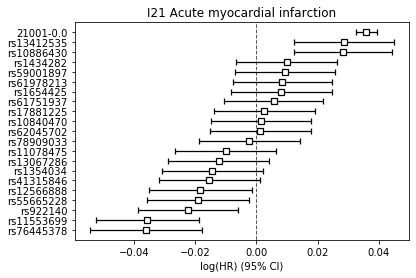

In [33]:
code = "I21"
code, p_val, n_cases, desc, aft1, aft2, X_1, X_2 = do_cox_test_all_SNPs_together((code, all_ICD10_events.loc[all_ICD10_events.code == code]),phenos=pheno_cols)

In [34]:
aft1.hazard_ratios_

covariate
21001-0.0    1.036417
Name: exp(coef), dtype: float64

In [90]:
comp = pd.merge(betas.T["ADP_pred"],-np.log(aft2.hazard_ratios_),how="inner",left_index=True,right_index=True)

In [93]:
conf = aft2.confidence_intervals_
conf = -conf.rename(columns={"95% lower-bound":"low","95% upper-bound":"high"})

In [98]:
comp = pd.merge(comp, conf, left_index=True,right_index=True)

In [99]:
from scipy.stats import pearsonr
pearsonr(comp["ADP_pred"],comp["exp(coef)"])

(0.2551466377180561, 0.2776229083889789)

Text(0.5, 0, '$\\beta$ in GWAS')

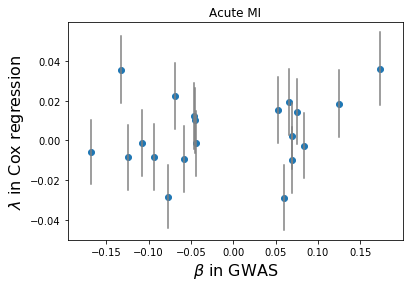

In [103]:
plt.scatter(comp["ADP_pred"],comp["exp(coef)"])
for i, row in comp.iterrows():
    row["exp(coef)"]
    row["ADP_pred"]
    plt.plot([row["ADP_pred"],row["ADP_pred"]],[row["high"],row["low"]],c="grey")
    #plt.text(row["ADP_pred"],row["exp(coef)"],i)
plt.title("Acute MI")
plt.ylabel("$\lambda$ in Cox regression",fontsize=16)
plt.xlabel("$\\beta$ in GWAS",fontsize=16)

/home/hv270/platelets/lib/python3.7/site-packages/lifelines/fitters/coxph_fitter.py:953: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  ax = plt.figure().add_subplot(1, 1, 1)


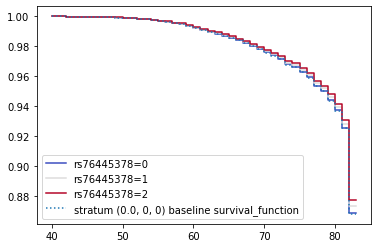

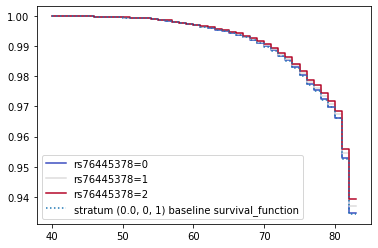

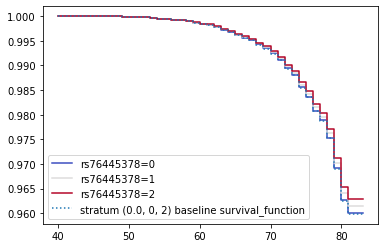

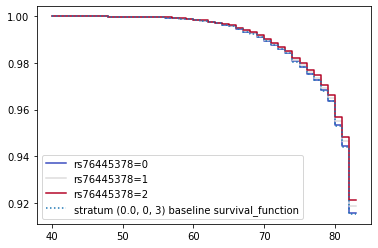

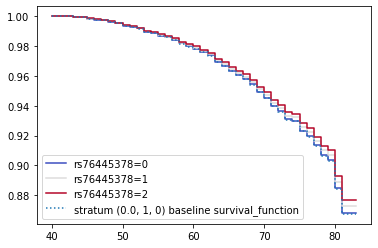

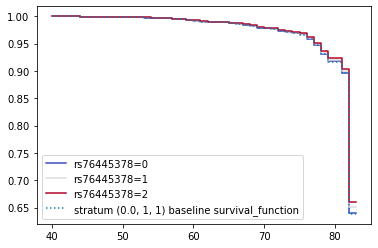

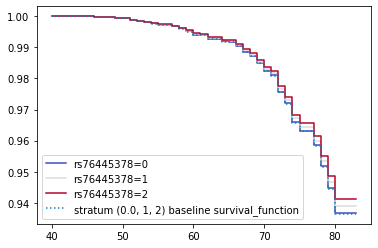

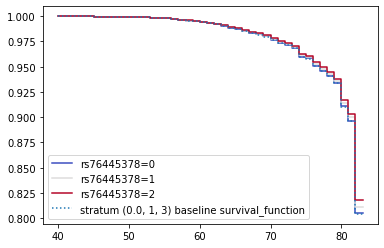

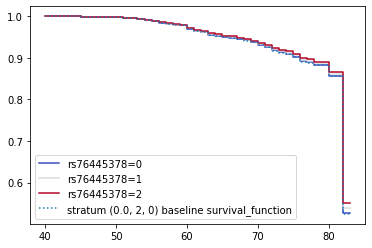

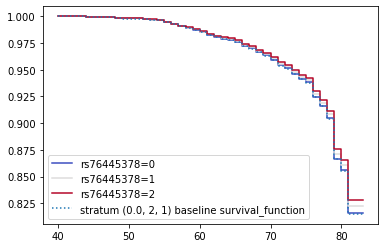

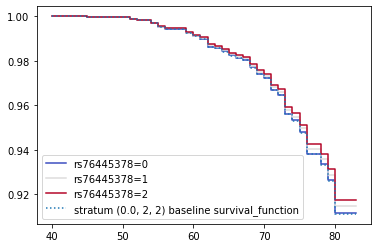

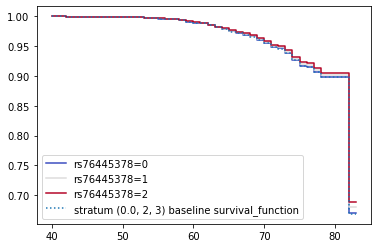

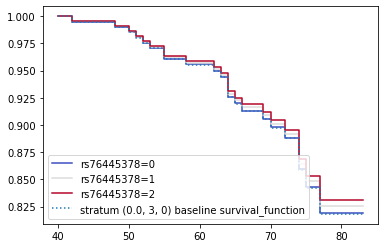

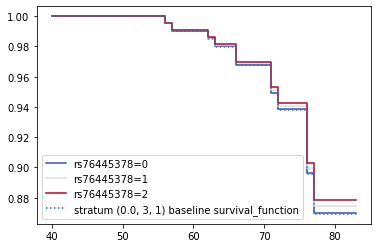

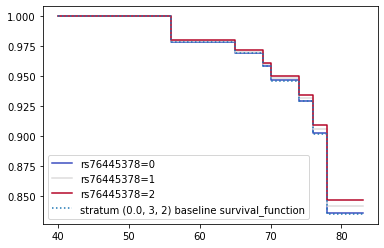

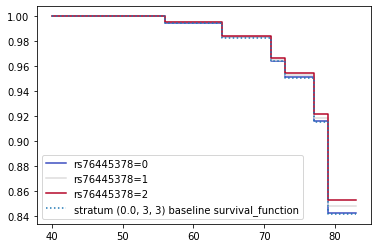

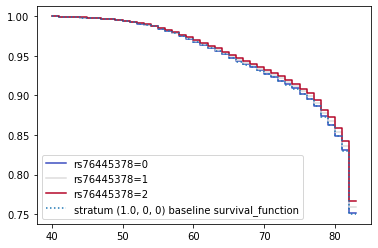

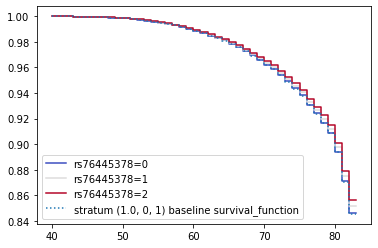

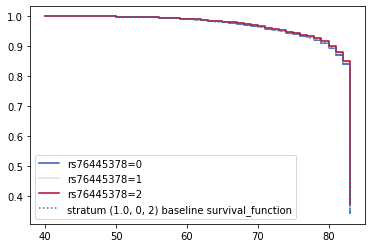

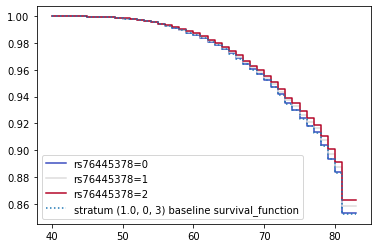

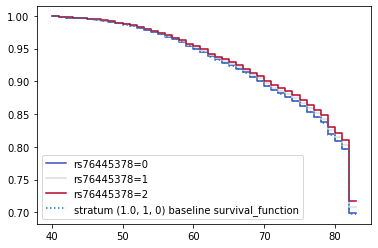

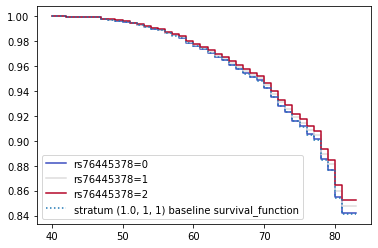

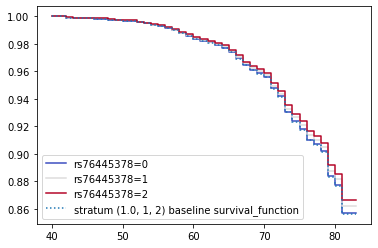

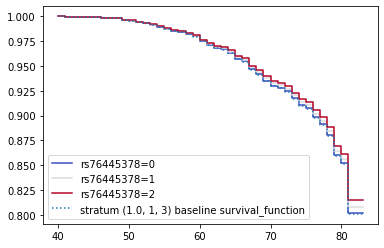

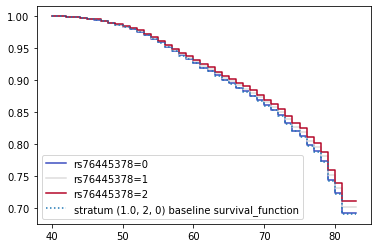

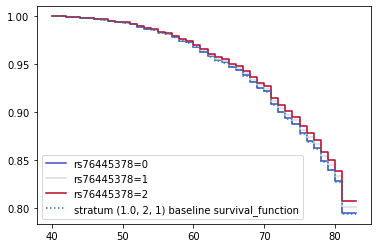

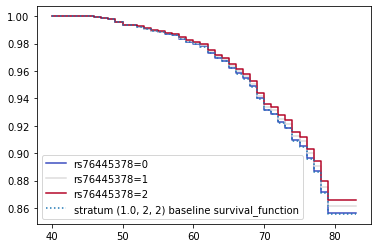

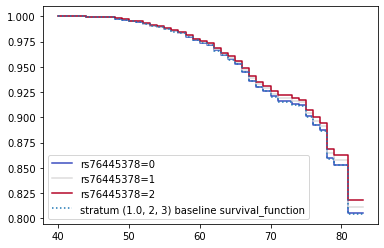

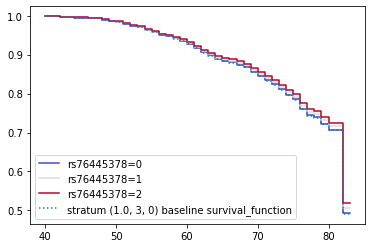

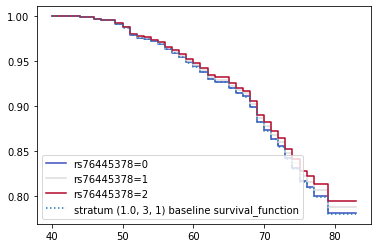

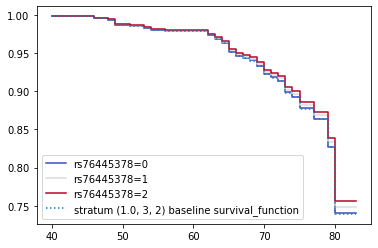

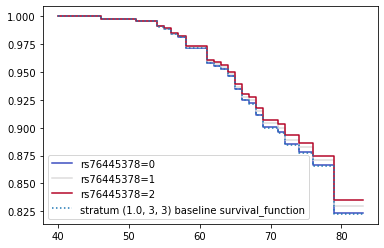

In [36]:
aft2.plot_partial_effects_on_outcome(covariates="rs76445378", values=[0, 1, 2], cmap='coolwarm');

## Call on all

In [35]:
p = Pool(32)

codes_ = []
descs_ = []
n_cases_ = []
P_ = []
HR_ = []
phenos_ = []
covs_ = []
afts_ = []

do_cox_test_pheno = partial(do_cox_test_all_SNPs_together,phenos=pheno_cols)
for _ in tqdm(p.imap_unordered(do_cox_test_pheno, all_ICD10_events.loc[cond].groupby("code")),
              total=all_ICD10_events.loc[cond].code.nunique()):
    if _ is None: continue
    code, p_val, n_cases, desc, aft = _
    P_.append(p_val)
    codes_.append(code)
    descs_.append(desc)
    n_cases_.append(n_cases)
    afts_.append(aft)
    
p.close()
p.join()

  2%|▎         | 36/1440 [02:21<10:23,  2.25it/s]  

| environmental : 4.26	1578 cases 	 C16 	 C16 Malignant neoplasm of stomach


  4%|▍         | 55/1440 [04:14<3:36:21,  9.37s/it]

| environmental : 5.00	2796 cases 	 C25 	 C25 Malignant neoplasm of pancreas


  4%|▍         | 60/1440 [04:25<1:19:45,  3.47s/it]

| environmental : 3.66	8264 cases 	 C34 	 C34 Malignant neoplasm of bronchus and lung


  4%|▍         | 64/1440 [04:28<28:42,  1.25s/it]  

| environmental : 3.18	23073 cases 	 C44 	 C44 Other malignant neoplasms of skin


  5%|▌         | 79/1440 [04:38<42:42,  1.88s/it]

| environmental : 3.99	4684 cases 	 C67 	 C67 Malignant neoplasm of bladder


  9%|▊         | 125/1440 [07:06<16:52,  1.30it/s]  

| environmental : 3.40	33366 cases 	 D12 	 D12 Benign neoplasm of colon, rectum, anus and anal canal


 12%|█▏        | 176/1440 [10:05<1:14:52,  3.55s/it]

| environmental : 5.37	3148 cases 	 E10.9 	 E10.9 Without complications


 12%|█▏        | 177/1440 [10:06<1:01:42,  2.93s/it]

| environmental : 14.95	4715 cases 	 E10 	 E10 Insulin-dependent diabetes mellitus


 12%|█▎        | 180/1440 [10:26<2:08:45,  6.13s/it]/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10


| environmental : inf	21312 cases 	 E03 	 E03 Other hypothyroidism


 13%|█▎        | 181/1440 [10:28<1:38:55,  4.71s/it]/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10


| environmental : inf	21060 cases 	 E03.9 	 E03.9 Hypothyroidism, unspecified


 14%|█▍        | 201/1440 [12:16<1:15:33,  3.66s/it]

| environmental : 3.45	26566 cases 	 E66 	 E66 Obesity


 17%|█▋        | 248/1440 [14:54<30:54,  1.56s/it]  

| environmental : 3.50	2790 cases 	 G30 	 G30 Alzheimer's disease


 17%|█▋        | 249/1440 [14:55<28:46,  1.45s/it]

| environmental : 3.31	2209 cases 	 G30.9 	 G30.9 Alzheimer's disease, unspecified


 22%|██▏       | 318/1440 [19:39<1:44:58,  5.61s/it]

| environmental : 3.06	8871 cases 	 H35 	 H35 Other retinal disorders


 22%|██▏       | 322/1440 [19:42<36:18,  1.95s/it]  

| environmental : 5.94	12011 cases 	 H40 	 H40 Glaucoma


 23%|██▎       | 328/1440 [20:01<58:16,  3.14s/it]  

| environmental : 4.09	1276 cases 	 H50 	 H50 Other strabismus


 25%|██▌       | 362/1440 [22:32<1:23:19,  4.64s/it]

| environmental : 5.52	109869 cases 	 I10 	 I10 Essential (primary) hypertension


 25%|██▌       | 365/1440 [22:41<1:05:43,  3.67s/it]

| environmental : 10.20	14148 cases 	 I21 	 I21 Acute myocardial infarction


 27%|██▋       | 383/1440 [24:12<1:07:43,  3.84s/it]/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10


| environmental : inf	6885 cases 	 I26 	 I26 Pulmonary embolism


 27%|██▋       | 384/1440 [24:13<52:56,  3.01s/it]  /home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10


| environmental : inf	6735 cases 	 I26.9 	 I26.9 Pulmonary embolism without mention of acute cor pulmonale


 27%|██▋       | 386/1440 [24:21<1:04:32,  3.67s/it]

| environmental : 11.14	70276 cases 	 I25 	 I25 Chronic ischaemic heart disease


 29%|██▉       | 424/1440 [26:44<31:39,  1.87s/it]  

| environmental : 4.29	7018 cases 	 I63 	 I63 Cerebral infarction


 30%|██▉       | 428/1440 [26:52<29:30,  1.75s/it]

| environmental : 3.46	13118 cases 	 I51 	 I51 Complications and ill-defined descriptions of heart disease


 30%|███       | 437/1440 [27:08<18:08,  1.09s/it]

| environmental : 3.87	16658 cases 	 I50 	 I50 Heart failure


 31%|███       | 443/1440 [27:23<45:34,  2.74s/it]

| environmental : 3.29	2847 cases 	 I69 	 I69 Sequelae of cerebrovascular disease


 31%|███       | 448/1440 [27:33<22:44,  1.38s/it]  

| environmental : 3.05	1727 cases 	 I69.4 	 I69.4 Sequelae of stroke, not specified as haemorrhage or infarction


 32%|███▏      | 458/1440 [29:02<2:25:27,  8.89s/it]

| environmental : 4.67	4367 cases 	 I80.2 	 I80.2 Phlebitis and thrombophlebitis of other deep vessels of lower extremities


 32%|███▏      | 465/1440 [29:16<48:32,  2.99s/it]  

| environmental : 8.20	6309 cases 	 I80 	 I80 Phlebitis and thrombophlebitis


 36%|███▌      | 519/1440 [32:30<1:21:55,  5.34s/it]

| environmental : 3.27	1862 cases 	 J92 	 J92 Pleural plaque


 36%|███▋      | 523/1440 [32:34<30:08,  1.97s/it]  

| environmental : 3.11	34336 cases 	 J45 	 J45 Asthma


 36%|███▋      | 525/1440 [32:39<32:36,  2.14s/it]

| environmental : 3.32	1004 cases 	 J92.9 	 J92.9 Pleural plaque without asbestos


 41%|████▏     | 595/1440 [37:49<56:11,  3.99s/it]  

| environmental : 3.48	18420 cases 	 K52 	 K52 Other non-infective gastro-enteritis and colitis


 42%|████▏     | 608/1440 [38:54<37:22,  2.69s/it]  

| environmental : 3.34	55438 cases 	 K57 	 K57 Diverticular disease of intestine


 43%|████▎     | 626/1440 [39:55<1:03:34,  4.69s/it]

| environmental : 3.29	26392 cases 	 K63 	 K63 Other diseases of intestine


 44%|████▍     | 639/1440 [40:59<1:23:22,  6.25s/it]

| environmental : 5.08	2035 cases 	 K74 	 K74 Fibrosis and cirrhosis of liver


 45%|████▌     | 649/1440 [41:39<31:47,  2.41s/it]  

| environmental : 3.75	8788 cases 	 K76 	 K76 Other diseases of liver


 47%|████▋     | 672/1440 [42:51<1:23:15,  6.50s/it]

| environmental : 6.00	2879 cases 	 K90 	 K90 Intestinal malabsorption


 47%|████▋     | 676/1440 [43:03<56:59,  4.48s/it]  

| environmental : 7.63	2381 cases 	 K90.0 	 K90.0 Coeliac disease


 50%|█████     | 720/1440 [46:19<59:56,  5.00s/it]  

| environmental : 3.50	2593 cases 	 M06.99 	 M06.99 Rheumatoid arthritis, unspecified (Site unspecified)
| environmental : 13.06	11231 cases 	 M06 	 M06 Other rheumatoid arthritis


 50%|█████     | 726/1440 [46:51<1:04:07,  5.39s/it]

| environmental : 3.71	8340 cases 	 M10 	 M10 Gout


 59%|█████▉    | 849/1440 [54:34<41:58,  4.26s/it]  

| environmental : 3.57	24331 cases 	 M79 	 M79 Other soft tissue disorders, not elsewhere classified


 60%|█████▉    | 861/1440 [55:11<36:58,  3.83s/it]

| environmental : 3.34	15548 cases 	 M81 	 M81 Osteoporosis without pathological fracture


 62%|██████▏   | 893/1440 [57:20<35:16,  3.87s/it]  

| environmental : 3.98	2378 cases 	 N41 	 N41 Inflammatory diseases of prostate (unisex)


 93%|█████████▎| 1335/1440 [1:19:41<03:51,  2.21s/it]  

| environmental : 3.49	36702 cases 	 Z51 	 Z51 Other medical care


 96%|█████████▌| 1380/1440 [1:23:02<05:06,  5.10s/it]

| environmental : 6.80	111018 cases 	 Z86 	 Z86 Personal history of certain other diseases


 96%|█████████▌| 1383/1440 [1:23:15<04:26,  4.68s/it]

| environmental : 12.69	27736 cases 	 Z86.7 	 Z86.7 Personal history of diseases of the circulatory system


 97%|█████████▋| 1398/1440 [1:24:05<02:27,  3.51s/it]

| environmental : 6.52	57149 cases 	 Z88 	 Z88 Personal history of allergy to drugs, medicaments and biologocal substances


 98%|█████████▊| 1414/1440 [1:25:30<02:15,  5.22s/it]

| environmental : 3.88	23486 cases 	 Z92.1 	 Z92.1 Personal history of long-term (current) use of anticoagulants


 98%|█████████▊| 1415/1440 [1:25:30<01:34,  3.79s/it]

| environmental : 4.72	72241 cases 	 Z92 	 Z92 Personal history of medical treatment


100%|██████████| 1440/1440 [1:26:35<00:00,  3.61s/it]


In [71]:
cox_all = pd.DataFrame.from_dict({"P":P_,"n":n_cases_,"code":codes_,"description":descs_})
cox_all.sort_values("P").head(5)

,P,n,code,description
135,0.000000e+00,21060,E03.9,"E03.9 Hypothyroidism, unspecified"
306,0.000000e+00,6885,I26,I26 Pulmonary embolism
307,0.000000e+00,6735,I26.9,I26.9 Pulmonary embolism without mention of ac...
134,0.000000e+00,21312,E03,E03 Other hypothyroidism
132,1.110223e-15,4715,E10,E10 Insulin-dependent diabetes mellitus


In [102]:
recap_HR = pd.DataFrame.from_dict({"%s - %s" % (codes_[i],descs_[i]):-np.log(afts_[i].hazard_ratios_) for i in range(len(codes_))}).T
recap_HR["code"] = recap_HR.reset_index()["index"].str.split(" - ",expand=True)[0].values

In [103]:
SNP_cols = [c for c in recap_HR.columns if "rs" in c]

In [104]:
cox_recap = pd.merge(cox_all, recap_HR, left_on="code",right_on="code")

In [105]:
cox_recap.head()

,P,n,code,description,21001-0.0,rs12566888,rs1434282,rs41315846,rs13412535,rs78909033,...,rs55665228,rs61751937,rs10886430,rs10840470,rs11553699,rs61978213,rs59001897,rs62045702,rs11078475,rs1654425
0,0.127384,1574,C15.9,"C15.9 Oesophagus, unspecified",-0.020358,-0.045005,0.003256,-0.018885,0.042895,-0.025440,...,-0.006604,-0.047718,0.033683,0.016766,0.037860,0.002393,0.014479,0.016391,0.037568,-0.025638
1,0.067407,2106,B98.0,B98.0 Helicobacter pylori [H.pylori] as the ca...,-0.013722,-0.009847,0.002078,-0.028948,0.015659,0.023368,...,0.025339,0.006779,-0.000359,0.024389,-0.005783,0.014896,-0.048901,0.047552,0.020587,0.055693
2,0.697170,1474,B96.5,B96.5 Pseudomonas (aeruginosa)(mallei)(pseudom...,-0.035703,0.022533,-0.025941,-0.024385,-0.021664,-0.008368,...,0.038281,0.013909,0.011125,-0.023235,0.025973,-0.027664,0.000576,0.010314,0.029798,-0.001877
3,0.271514,1689,C18.9,"C18.9 Colon, unspecified",-0.011048,0.025423,-0.045438,0.030474,-0.010343,0.023194,...,0.001799,-0.011045,-0.035846,-0.002474,0.000996,-0.039446,0.014864,-0.044313,0.032202,-0.019843
4,0.442769,2127,B37.0,B37.0 Candidal stomatitis,-0.020356,0.010834,0.027436,0.013981,0.033294,-0.005344,...,-0.015937,-0.012249,0.005182,-0.007787,-0.010988,-0.025694,0.043602,-0.005843,0.022607,0.013799


In [106]:
cox_recap.to_csv("/home/hv270/cox/multivar_cox_results.csv")

## Look at correlation of GWAS Betas and lambdas

### Only on hits

In [41]:
cox_recap = pd.read_csv("/home/hv270/cox/multivar_cox_results.csv",index_col=0)
SNP_cols = [c for c in cox_recap.columns if "rs" in c]

In [42]:
cox_hits = cox_recap.loc[cox_recap.P < 1e-5]

In [45]:
norm = matplotlib.colors.DivergingNorm(vmin=np.quantile(cox_hits[SNP_cols].values,.05),
                                       vcenter=0.,
                                       vmax=np.quantile(cox_hits[SNP_cols].values,.95))

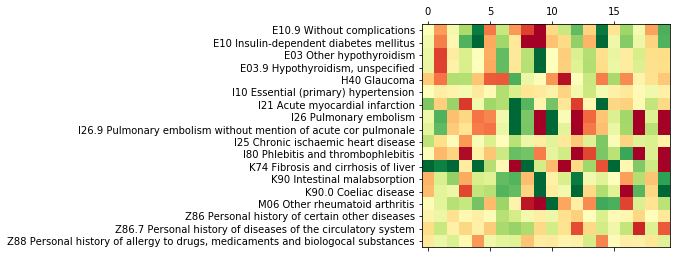

In [46]:
plt.matshow(cox_hits[SNP_cols].values,norm=norm,cmap="RdYlGn")
plt.yticks(np.arange(cox_hits.shape[0]),cox_hits.description);

In [47]:
gwas_results = pd.read_csv("/home/hv270/sysmex2pf/GWAS_table.csv",index_col=0)

In [48]:
cox_hits.head(3)

,P,n,code,description,21001-0.0,rs12566888,rs1434282,rs41315846,rs13412535,rs78909033,...,rs55665228,rs61751937,rs10886430,rs10840470,rs11553699,rs61978213,rs59001897,rs62045702,rs11078475,rs1654425
131,4.239682e-06,3148,E10.9,E10.9 Without complications,-0.068860,0.000300,-0.016893,0.002219,0.013350,0.031917,...,-0.008336,0.009218,0.021256,-0.009151,0.032593,-0.006203,0.014611,0.002077,-0.016344,0.023384
132,1.110223e-15,4715,E10,E10 Insulin-dependent diabetes mellitus,-0.054482,0.002237,-0.020378,-0.001831,0.023012,0.035189,...,-0.011915,-0.007936,0.016066,-0.013566,0.034663,0.002856,0.017346,0.003101,-0.009191,0.022853
134,0.000000e+00,21312,E03,E03 Other hypothyroidism,-0.051672,0.003481,-0.027908,-0.004308,0.006608,0.000501,...,0.000223,-0.010098,0.006516,0.011834,-0.007272,0.004007,-0.004151,0.007257,-0.007428,-0.007799


In [50]:
cox_lambdas = cox_hits.loc[cox_hits.code.isin(coag_related_codes)].set_index("description")[SNP_cols].T

In [51]:
cox_lambdas.head(3)

description,H40 Glaucoma,I10 Essential (primary) hypertension,I21 Acute myocardial infarction,I26 Pulmonary embolism,I80 Phlebitis and thrombophlebitis
rs12566888,-0.010555,-0.000505,0.018410,0.003006,0.000743
rs1434282,-0.021629,-0.004072,-0.009861,0.022987,-0.013004
rs41315846,0.012239,-0.002841,0.015367,-0.012216,-0.009340


In [52]:
gwas_results.head(3)

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,F_MISS,BETA,SE,...,CLIN_SIG,SOMATIC,PHENO,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,TRANSCRIPTION_FACTORS,was_in_NY_GWAS
0,rs12566888,1,156869047,0,G,T,0.909454,0.003681,0.124848,0.012357,...,-,-,1,"29865896,20526338,27641736,28002340,29407631,2...",-,-,-,-,-,True
1,rs1434282,1,199010721,0,C,T,0.264595,0.066475,0.069782,0.008351,...,-,-,1,"27863252,29403010,30595370,32888493",-,-,-,-,-,False
2,rs41315846,1,247712303,0,T,C,0.526638,0.095375,0.052608,0.007460,...,-,"0,0,1","1,1,1","27668658,27863252",-,-,-,-,-,False


In [53]:
comp = pd.merge(cox_lambdas, gwas_results[["SNP","BETA"]], left_index=True,right_on="SNP")

In [54]:
comp.head(3)

,H40 Glaucoma,I10 Essential (primary) hypertension,I21 Acute myocardial infarction,I26 Pulmonary embolism,I80 Phlebitis and thrombophlebitis,SNP,BETA
0,-0.010555,-0.000505,0.018410,0.003006,0.000743,rs12566888,0.124848
1,-0.021629,-0.004072,-0.009861,0.022987,-0.013004,rs1434282,0.069782
2,0.012239,-0.002841,0.015367,-0.012216,-0.009340,rs41315846,0.052608


In [55]:
N = cox_lambdas.shape[1]
L = np.sqrt(N) + 1

(0.19469154535775193, 0.05225161881619717)


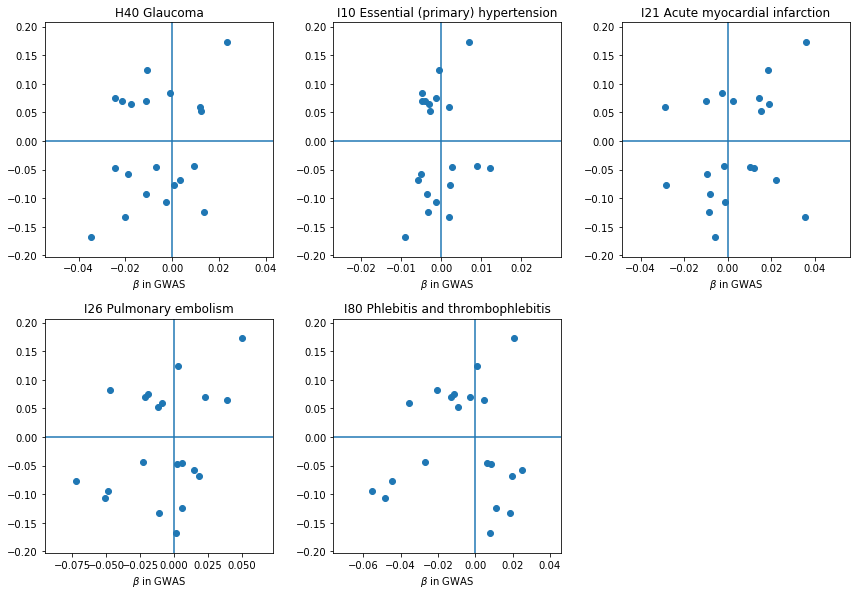

In [58]:
fig = plt.figure(figsize=(12,12))
lambdas = []
betas = []
for i in range(N):
    ax = fig.add_subplot(L,L,i+1)
    lambdas.append(comp.iloc[:,i].values)
    betas.append(comp["BETA"].values)
    ax.scatter(comp.iloc[:,i],comp["BETA"])
    ax.set_xlabel("$\\lambda$ in Cox regression")
    ax.set_xlabel("$\\beta$ in GWAS")
    ax.set_title(comp.columns[i])
    ax.axvline(0)
    ax.axhline(0)
    #plt.axis("off")
plt.tight_layout()
betas = np.concatenate(betas,axis=0)
lambdas = np.concatenate(lambdas,axis=0)
print(pearsonr(betas, lambdas))

(0.31423958124698115, 0.1772366992185617)


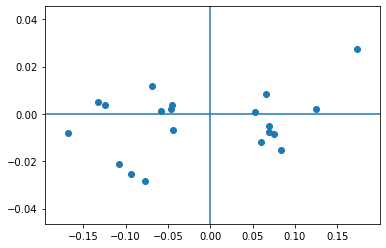

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111)
mean_lambda = cox_lambdas.mean(axis=1)
print(pearsonr(mean_lambda,comp["BETA"]))
ax.scatter(comp["BETA"],mean_lambda)
ax.axhline(0.)
ax.axvline(0.)

### On all ICD10

In [71]:
cox_lambdas = cox.set_index("description")[SNP_cols].T
comp = pd.merge(cox_lambdas, gwas_results[["SNP","BETA"]], left_index=True,right_on="SNP")

NameError: name 'SNP_cols' is not defined

In [64]:
comp.sample(3)

,"C15.9 Oesophagus, unspecified",B98.0 Helicobacter pylori [H.pylori] as the cause of diseases classified to other chapters,B96.5 Pseudomonas (aeruginosa)(mallei)(pseudomallei) as the cause of diseases classified to other chapters,"C18.9 Colon, unspecified",B37.0 Candidal stomatitis,B37.8 Candidiasis of other sites,C15 Malignant neoplasm of oesophagus,B96.8 Other specified bacterial agents as the cause of diseases classified to other chapters,"A41.9 Septicaemia, unspecified","A08.4 Viral intestinal infection, unspecified",...,Z96.6 Presence of orthopaedic joint implants,Z98.0 Intestinal bypass and anastomosis status,Z98 Other postsurgical states,Z98.8 Other specified postsurgical states,Z99.3 Dependence on wheelchair,Z99.1 Dependence on respirator,Z99.8 Dependence on other enabling machines and devices,"Z99 Dependence on enabling machines and devices, not elsewhere classified",SNP,BETA
9,0.037257,-0.017136,-0.029363,0.031083,0.006489,0.033107,0.030543,-0.007140,0.000545,0.014214,...,0.004290,-0.044786,-0.028053,0.020710,0.047465,-0.034871,-0.011785,0.006877,rs17881225,0.083159
13,0.016766,0.024389,-0.023235,-0.002474,-0.007787,-0.030657,0.011611,0.004140,-0.001758,-0.034988,...,0.005582,0.041353,0.036929,0.012864,0.069445,-0.025286,-0.012152,0.009480,rs10840470,-0.043570
12,0.033683,-0.000359,0.011125,-0.035846,0.005182,-0.029040,0.023467,-0.003345,0.001780,-0.000451,...,-0.000654,-0.015091,-0.011181,0.009619,0.041180,0.050351,-0.003599,0.032228,rs10886430,-0.076809


In [65]:
rows = []
for c in comp.columns:
    row = {}
    print(c, pearsonr(comp[c],comp["BETA"])[0])

C15.9 Oesophagus, unspecified -0.29442937496186644
B98.0 Helicobacter pylori [H.pylori] as the cause of diseases classified to other chapters -0.27160569069491886
B96.5 Pseudomonas (aeruginosa)(mallei)(pseudomallei) as the cause of diseases classified to other chapters 0.026614603637249795
C18.9 Colon, unspecified 0.25114969346921157
B37.0 Candidal stomatitis 0.3427506408271773
B37.8 Candidiasis of other sites 0.009883964049182983
C15 Malignant neoplasm of oesophagus -0.34718111038998356
B96.8 Other specified bacterial agents as the cause of diseases classified to other chapters 0.286767126357694
A41.9 Septicaemia, unspecified -0.41015523992411845
A08.4 Viral intestinal infection, unspecified -0.08434947189401057
B96.2 Escherichia coli [E. coli] as the cause of diseases classified to other chapters 0.4162282203006261
B97 Viral agents as the cause of diseases classified to other chapters 0.07150467757803364
B98 Other specified infectious agents as the cause of diseases classified to oth

N88 Other noninflammatory disorders of cervix uteri (unisex) -0.13045548536173282
N85.8 Other specified noninflammatory disorders of uterus (unisex) -0.16890581682862144
N88.8 Other specified noninflammatory disorders of cervix uteri (unisex) -0.11253921374637502
N89.8 Other specified noninflammatory disorders of vagina (unisex) -0.1390245555603141
N89 Other noninflammatory disorders of vagina (unisex) -0.29955672023872143
N90 Other noninflammatory disorders of vulva and perineum (unisex) -0.17215859164573774
N92 Excessive, frequent and irregular menstruation (unisex) -0.16927482035952202
N92.0 Excessive and frequent menstruation with regular cycle (unisex) -0.23633439891060526
N92.1 Excessive and frequent menstruation with irregular cycle (unisex) 0.07405410719981866
N92.6 Irregular menstruation, unspecified (unisex) 0.10853644428749153
N93.9 Abnormal uterine and vaginal bleeding, unspecified (unisex) -0.06668758322852747
N63 Unspecified lump in breast 0.26670425522232905
N93.8 Other 

TypeError: unsupported operand type(s) for +: 'float' and 'str'

# Test SNPs separately

In [44]:
#pheno_cols = [c for c in list(scores.columns) if c not in sysmex_covars]
pheno_cols = ["best_pval_score_homogenous"]
for c in pheno_cols:
    assert c in scores.columns

In [45]:
pheno_cols

['best_pval_score_homogenous']

In [46]:
run_name = "test_all_strata"
run_dir = "/home/hv270/cox/%s" % run_name
force_recompute = True
if not os.path.exists(run_dir):
    os.mkdir(run_dir)


code_file = lambda code: "%s/%s.csv" % (run_dir, code)

n_events = all_ICD10_events.code.value_counts()
large_events = n_events.loc[n_events >= min_n_cases].index.tolist()
cond = all_ICD10_events.code.isin(large_events) & ~all_ICD10_events.code.isin(diabetes_codes)

already_processed_codes = [c for c in all_ICD10_events.loc[cond].code.unique().tolist() if os.path.exists(code_file(c))]
print("%d already processed codes" % len(already_processed_codes))
if not force_recompute:
    cond = cond & ~all_ICD10_events.code.isin(already_processed_codes)

#codes_to_focus_on = ["D69","D69.6"] # Thrombosis
codes_to_focus_on = []
#codes_to_focus_on = ["I26","I26.9","Z86.7","I21","I80","D69","meta_coag","D69.6","I25","M72.04","I51","T43"]
if len(codes_to_focus_on) > 0:
    cond = cond & all_ICD10_events.code.isin(codes_to_focus_on)
n_codes_to_process = all_ICD10_events.loc[cond].code.nunique()
print("%d codes to process" % n_codes_to_process)

1162 already processed codes
1435 codes to process


In [133]:
thrombosis_codes = [
    #"I26", # Pulmonary embolism
    #"I82", # Other venous embolism
    "I2",
    "I8",
]
anti_coag_codes = ["Z92.1","T45.5","Y44.2"]
IDs_no_thrombosis = X.index.tolist()
for code in thrombosis_codes:
    to_exclude = all_ICD10_events.loc[all_ICD10_events.code.str.contains(code)].ID.unique().tolist()
    IDs_no_thrombosis = list(set(IDs_no_thrombosis).difference(set(to_exclude)))
print("%d thrombosis patients" % (len(X.index.tolist()) - len(IDs_no_thrombosis)))

IDs_no_anti_coag = X.index.tolist()
for code in anti_coag_codes:
    to_exclude = all_ICD10_events.loc[all_ICD10_events.code.str.contains(code)].ID.unique().tolist()
    IDs_no_anti_coag = list(set(IDs_no_anti_coag).difference(set(to_exclude)))
print("%d anti-coag patients" % (len(X.index.tolist()) - len(IDs_no_anti_coag)))


79552 thrombosis patients
22553 anti-coag patients


In [134]:
X["thrombotic_event"] = ~X.index.isin(IDs_no_thrombosis)
X["anti_coag"] = ~X.index.isin(IDs_no_anti_coag)

In [135]:
X.groupby(["thrombotic_event","anti_coag"])[["31-0.0"]].count()

31-0.0
thrombotic_event anti_coag        
False            False      279252
                 True         8588
True             False       65587
                 True        13965

In [47]:
p = Pool(32)

do_cox_test_pheno = partial(do_cox_test,covars=pheno_cols)#,IDs_to_include = IDs_no_anti_coag
for _ in tqdm(p.imap_unordered(do_cox_test_pheno, all_ICD10_events.loc[cond].groupby("code")),
              total=n_codes_to_process):
    if _ is None: continue
    code, p_vals, n_cases, desc, HRs, covs, phenos = _
    codes_ = []
    descs_ = []
    n_cases_ = []
    P_ = []
    HR_ = []
    phenos_ = []
    covs_ = []
    for i in range(len(p_vals)):
        HR_.append(HRs[i])
        P_.append(p_vals[i])
        covs_.append(covs[i])
        codes_.append(code)
        descs_.append(desc)
        n_cases_.append(n_cases)
        phenos_.append(phenos[i])
    df = pd.DataFrame.from_dict(
        {"HR":HR_,"P":P_,"code":codes_,
         "covars":covs_,"desc":descs_,
         "n":n_cases_,"SNP":phenos_},
        orient="columns")
    df.to_csv(code_file(code))
p.close()
p.join()

 12%|█▏        | 169/1435 [34:32<2:03:22,  5.85s/it] 

| best_pval_score_homogenous 	| none : 4.07	3122 cases 	 D69 	 D69 Purpura and other haemorrhagic conditions


 12%|█▏        | 170/1435 [34:37<1:53:11,  5.37s/it]

| best_pval_score_homogenous 	| none : 4.53	2207 cases 	 D69.6 	 D69.6 Thrombocytopenia, unspecified


 25%|██▍       | 358/1435 [1:16:32<2:27:08,  8.20s/it] 

| best_pval_score_homogenous 	| none : 6.14	14198 cases 	 I21 	 I21 Acute myocardial infarction


 25%|██▌       | 364/1435 [1:17:45<2:42:43,  9.12s/it]

| best_pval_score_homogenous 	| none : 3.44	3030 cases 	 I24 	 I24 Other acute ischaemic heart diseases


 26%|██▌       | 370/1435 [1:18:34<1:56:09,  6.54s/it]

| best_pval_score_homogenous 	| none : 5.40	70395 cases 	 I25 	 I25 Chronic ischaemic heart disease


 26%|██▌       | 373/1435 [1:18:58<2:20:57,  7.96s/it]

| best_pval_score_homogenous 	| none : 6.74	6942 cases 	 I26 	 I26 Pulmonary embolism


 26%|██▌       | 374/1435 [1:19:02<1:58:21,  6.69s/it]

| best_pval_score_homogenous 	| none : 6.27	6792 cases 	 I26.9 	 I26.9 Pulmonary embolism without mention of acute cor pulmonale


 29%|██▉       | 414/1435 [1:27:33<1:45:19,  6.19s/it] 

| best_pval_score_homogenous 	| none : 3.03	16676 cases 	 I50 	 I50 Heart failure


 31%|███▏      | 451/1435 [1:35:21<2:29:56,  9.14s/it] 

| best_pval_score_homogenous 	| none : 3.38	6408 cases 	 I80 	 I80 Phlebitis and thrombophlebitis


 57%|█████▋    | 818/1435 [2:57:12<1:16:49,  7.47s/it] 

| best_pval_score_homogenous 	| none : 3.52	1611 cases 	 M62 	 M62 Other disorders of muscle


 59%|█████▉    | 848/1435 [3:04:01<2:15:53, 13.89s/it]

| best_pval_score_homogenous 	| none : 3.62	15583 cases 	 M81 	 M81 Osteoporosis without pathological fracture


 95%|█████████▌| 1369/1435 [4:36:40<17:30, 15.92s/it]  

| best_pval_score_homogenous 	| none : 3.66	111604 cases 	 Z86 	 Z86 Personal history of certain other diseases


 96%|█████████▌| 1376/1435 [4:38:39<13:11, 13.41s/it]

| best_pval_score_homogenous 	| none : 3.70	27912 cases 	 Z86.7 	 Z86.7 Personal history of diseases of the circulatory system


100%|█████████▉| 1434/1435 [4:51:52<00:11, 11.08s/it]

| best_pval_score_homogenous 	| none : 5.84	54485 cases 	 meta_coag 	 Coag ICD10 code (DVT, CAD, PE, MI, glaucoma)


100%|██████████| 1435/1435 [4:52:45<00:00, 12.24s/it]


In [48]:
already_processed_codes = [c for c in all_ICD10_events.loc[cond].code.unique().tolist() if os.path.exists(code_file(c))]
print(len(already_processed_codes))

1183


In [49]:
dfs = []
for code in set(already_processed_codes):
    f = code_file(code)
    df = pd.read_csv(f,index_col=0)
    df["lambda"] = np.log(df["HR"])
    dfs.append(df)
cox = pd.concat(dfs,axis=0)
cox.to_csv("%s/cox_results.csv" % run_dir)

In [50]:
cox.sort_values("P").head(10)

,HR,P,code,covars,desc,n,SNP,lambda
0,1.069323,1.821778e-07,I26,none,I26 Pulmonary embolism,6942,best_pval_score_homogenous,0.067025
0,1.067270,5.336099e-07,I26.9,none,I26.9 Pulmonary embolism without mention of ac...,6792,best_pval_score_homogenous,0.065104
0,1.045384,7.288929e-07,I21,none,I21 Acute myocardial infarction,14198,best_pval_score_homogenous,0.044384
0,1.022357,1.442415e-06,meta_coag,none,"Coag ICD10 code (DVT, CAD, PE, MI, glaucoma)",54485,best_pval_score_homogenous,0.022111
0,1.018807,4.009378e-06,I25,none,I25 Chronic ischaemic heart disease,70395,best_pval_score_homogenous,0.018632
0,1.100230,2.974521e-05,D69.6,none,"D69.6 Thrombocytopenia, unspecified",2207,best_pval_score_homogenous,0.095520
0,1.078558,8.522187e-05,D69,none,D69 Purpura and other haemorrhagic conditions,3122,best_pval_score_homogenous,0.075625
0,1.024179,2.000258e-04,Z86.7,none,Z86.7 Personal history of diseases of the circ...,27912,best_pval_score_homogenous,0.023891
0,1.011956,2.188250e-04,Z86,none,Z86 Personal history of certain other diseases,111604,best_pval_score_homogenous,0.011885
0,1.032248,2.418879e-04,M81,none,M81 Osteoporosis without pathological fracture,15583,best_pval_score_homogenous,0.031739


## Analyze Cox Results (scores)

In [51]:
# run_name = "BGEN_SNPs"
# run_name = "BGEN_SNPs_no_covars"
# run_name = "BGEN_SNPs_no_covars_pfc_scores"
# run_name = "pfc_score_INTERVAL_hits_w_replacement"
# run_name = "test_no_save"
run_name = "test_all_strata"
run_dir = "/home/hv270/cox/%s" % run_name

In [52]:
cox = pd.read_csv("%s/cox_results.csv" % run_dir,index_col=0)

In [53]:
code_roots = cox["code"].str.split(".",expand=True)[0].unique().tolist()
n_indep_codes = len(code_roots)
p_threshold = 0.05 / n_indep_codes
cox["significative"] = cox.P < p_threshold

In [54]:
cox.sort_values("P").head(15)

,HR,P,code,covars,desc,n,SNP,lambda,significative
0,1.069323,1.821778e-07,I26,none,I26 Pulmonary embolism,6942,best_pval_score_homogenous,0.067025,True
0,1.067270,5.336099e-07,I26.9,none,I26.9 Pulmonary embolism without mention of ac...,6792,best_pval_score_homogenous,0.065104,True
0,1.045384,7.288929e-07,I21,none,I21 Acute myocardial infarction,14198,best_pval_score_homogenous,0.044384,True
0,1.022357,1.442415e-06,meta_coag,none,"Coag ICD10 code (DVT, CAD, PE, MI, glaucoma)",54485,best_pval_score_homogenous,0.022111,True
0,1.018807,4.009378e-06,I25,none,I25 Chronic ischaemic heart disease,70395,best_pval_score_homogenous,0.018632,True
0,1.100230,2.974521e-05,D69.6,none,"D69.6 Thrombocytopenia, unspecified",2207,best_pval_score_homogenous,0.095520,True
0,1.078558,8.522187e-05,D69,none,D69 Purpura and other haemorrhagic conditions,3122,best_pval_score_homogenous,0.075625,True
0,1.024179,2.000258e-04,Z86.7,none,Z86.7 Personal history of diseases of the circ...,27912,best_pval_score_homogenous,0.023891,False
0,1.011956,2.188250e-04,Z86,none,Z86 Personal history of certain other diseases,111604,best_pval_score_homogenous,0.011885,False
0,1.032248,2.418879e-04,M81,none,M81 Osteoporosis without pathological fracture,15583,best_pval_score_homogenous,0.031739,False


In [56]:
#cox.loc[cox.significative].to_csv("/home/hv270/cox_results.csv")

Text(0.5, 0, '$\\log_{10}(1/\\epsilon)$')

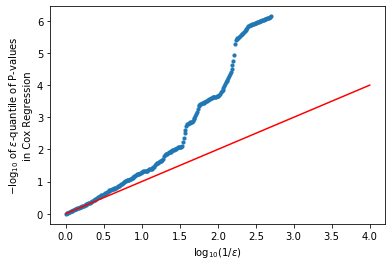

In [57]:
cox_primary = cox.loc[~cox.code.str.contains(".",regex=False)]
cox_primary = cox_primary.loc[cox_primary.SNP == "best_pval_score_homogenous"]
epsilon = np.logspace(-np.log10(cox_primary.shape[0]-3),0,250,endpoint=True)[::-1] # 1 -> 1e-5
plt.scatter(-np.log10(epsilon), [-np.log10(cox_primary.P.quantile(e)) for e in epsilon],s=10)
plt.plot([0,4],[0,4],c="red")
plt.ylabel("$-\\log_{10}$ of $\\epsilon$-quantile of P-values\nin Cox Regression")
plt.xlabel("$\\log_{10}(1/\\epsilon)$")

In [58]:
cox_primary.sort_values("P")

,HR,P,code,covars,desc,n,SNP,lambda,significative
0,1.069323,1.821778e-07,I26,none,I26 Pulmonary embolism,6942,best_pval_score_homogenous,0.067025,True
0,1.045384,7.288929e-07,I21,none,I21 Acute myocardial infarction,14198,best_pval_score_homogenous,0.044384,True
0,1.022357,1.442415e-06,meta_coag,none,"Coag ICD10 code (DVT, CAD, PE, MI, glaucoma)",54485,best_pval_score_homogenous,0.022111,True
0,1.018807,4.009378e-06,I25,none,I25 Chronic ischaemic heart disease,70395,best_pval_score_homogenous,0.018632,True
0,1.078558,8.522187e-05,D69,none,D69 Purpura and other haemorrhagic conditions,3122,best_pval_score_homogenous,0.075625,True
...,...,...,...,...,...,...,...,...,...
0,0.999900,9.934724e-01,K83,none,K83 Other diseases of biliary tract,4563,best_pval_score_homogenous,-0.000100,False
0,0.999881,9.938069e-01,H43,none,H43 Disorders of vitreous body,2926,best_pval_score_homogenous,-0.000119,False
0,1.000006,9.982845e-01,Z85,none,Z85 Personal history of malignant neoplasm,44463,best_pval_score_homogenous,0.000006,False
0,0.999980,9.987833e-01,R52,none,"R52 Pain, not elsewhere classified",2146,best_pval_score_homogenous,-0.000020,False


In [59]:
P_thresh = 0.05 / cox_primary.shape[0]

In [60]:
P_thresh

9.842519685039371e-05

In [61]:
cox_primary.loc[cox_primary.P < P_thresh].sort_values("P")

,HR,P,code,covars,desc,n,SNP,lambda,significative
0,1.069323,1.821778e-07,I26,none,I26 Pulmonary embolism,6942,best_pval_score_homogenous,0.067025,True
0,1.045384,7.288929e-07,I21,none,I21 Acute myocardial infarction,14198,best_pval_score_homogenous,0.044384,True
0,1.022357,1.442415e-06,meta_coag,none,"Coag ICD10 code (DVT, CAD, PE, MI, glaucoma)",54485,best_pval_score_homogenous,0.022111,True
0,1.018807,4.009378e-06,I25,none,I25 Chronic ischaemic heart disease,70395,best_pval_score_homogenous,0.018632,True
0,1.078558,8.522187e-05,D69,none,D69 Purpura and other haemorrhagic conditions,3122,best_pval_score_homogenous,0.075625,True


## Analyze Cox Results (per SNPs)

In [41]:
# run_name = "BGEN_SNPs"
run_name = "BGEN_SNPs_no_covars"
run_dir = "/home/hv270/cox/%s" % run_name

In [42]:
gwas_results = pd.read_csv("/home/hv270/sysmex2pf/GWAS_table.csv",index_col=0)
cox = pd.read_csv("%s/cox_results.csv" % run_dir,index_col=0)
cox = cox.merge(gwas_results[["SNP","SYMBOL","BETA"]],left_on="SNP",right_on="SNP",how="left")

code_roots = cox["code"].str.split(".",expand=True)[0].unique().tolist()
n_indep_codes = len(code_roots)
print("indep codes : %d " % n_indep_codes)

n_SNPs = gwas_results.shape[0]
threshold_P = 0.05 / (n_SNPs*(n_indep_codes+1))

cox["significant_all"] = cox.P < threshold_P
cox["significant_1"] = cox.P < threshold_P * n_SNPs
cox["good"] = cox.P < threshold_P * 10


print("significance threshold : %.2e " % threshold_P)

indep codes : 525 
significance threshold : 4.53e-06 


In [43]:
cox.loc[cox.significant_all].sort_values("P")

,HR,P,code,covars,desc,n,SNP,lambda,SYMBOL,BETA,significant_all,significant_1,good
18863,1.126748,0.000000e+00,E10,none,E10 Insulin-dependent diabetes mellitus,4904,rs3819288,0.119335,HLA-B,0.083528,True,True,True
17807,0.930906,0.000000e+00,E03,none,E03 Other hypothyroidism,21480,rs3819288,-0.071597,HLA-B,0.083528,True,True,True
14969,0.931376,0.000000e+00,E03.9,none,"E03.9 Hypothyroidism, unspecified",21225,rs3819288,-0.071093,HLA-B,0.083528,True,True,True
3771,0.846924,1.519895e-13,K90.0,none,K90.0 Coeliac disease,2444,rs3819288,-0.166144,HLA-B,0.083528,True,True,True
515,0.869565,3.391176e-12,K90,none,K90 Intestinal malabsorption,2963,rs3819288,-0.139762,HLA-B,0.083528,True,True,True
5047,1.113220,5.262724e-11,E10.9,none,E10.9 Without complications,3270,rs3819288,0.107257,HLA-B,0.083528,True,True,True
7822,1.075828,2.410441e-10,I26,none,I26 Pulmonary embolism,6942,rs10886430,0.073090,GRK5,-0.068886,True,True,True
25444,1.075604,4.224140e-10,I26.9,none,I26.9 Pulmonary embolism without mention of ac...,6792,rs10886430,0.072882,GRK5,-0.068886,True,True,True
11009,1.055464,2.744889e-09,M06,none,M06 Other rheumatoid arthritis,11321,rs3819288,0.053981,HLA-B,0.083528,True,True,True
18608,1.032108,8.777832e-08,Z86.7,none,Z86.7 Personal history of diseases of the circ...,27912,rs12445050,0.031604,PLCG2,-0.107511,True,True,True


In [44]:
cox.sort_values("P").groupby(["SNP"]).first().reset_index().sort_values("P")

,SNP,HR,P,code,covars,desc,n,lambda,SYMBOL,BETA,significant_all,significant_1,good
11,rs3819288,0.930906,0.000000e+00,E03,none,E03 Other hypothyroidism,21480,-0.071597,HLA-B,0.083528,True,True,True
1,rs10886430,1.075828,2.410441e-10,I26,none,I26 Pulmonary embolism,6942,0.073090,GRK5,-0.068886,True,True,True
4,rs12445050,1.032108,8.777832e-08,Z86.7,none,Z86.7 Personal history of diseases of the circ...,27912,0.031604,PLCG2,-0.107511,True,True,True
3,rs11553699,1.019909,1.571543e-06,Z88,none,"Z88 Personal history of allergy to drugs, medi...",58086,0.019713,TMEM120B,-0.134460,True,True,True
8,rs1354034,1.050216,1.710029e-06,C44.3,none,C44.3 Skin of other and unspecified parts of face,9623,0.048996,ARHGEF3,0.074894,True,True,True
6,rs13067286,1.113643,9.742867e-06,T43,none,"T43 Poisoning by psychotropic drugs, not elsew...",1687,0.107637,UMPS,-0.047616,False,True,True
7,rs13412535,1.016742,9.787015e-06,I25,none,I25 Chronic ischaemic heart disease,70395,0.016603,SERPINE2,0.057557,False,True,True
10,rs1654425,1.056761,1.567598e-05,I80,none,I80 Phlebitis and thrombophlebitis,6408,0.055208,GP6,-0.091918,False,True,True
20,rs8057254,1.036193,1.835269e-05,I21,none,I21 Acute myocardial infarction,14198,0.035553,USP7,-0.055509,False,True,True
19,rs78909033,1.017314,2.878190e-05,Z88,none,"Z88 Personal history of allergy to drugs, medi...",58086,0.017166,ANKMY1,0.069758,False,True,True


In [45]:
cox.sort_values("P").groupby(["code"]).first().reset_index().sort_values("P").head(30)

,code,HR,P,covars,desc,n,SNP,lambda,SYMBOL,BETA,significant_all,significant_1,good
135,E10,1.126748,0.000000e+00,none,E10 Insulin-dependent diabetes mellitus,4904,rs3819288,0.119335,HLA-B,0.083528,True,True,True
132,E03.9,0.931376,0.000000e+00,none,"E03.9 Hypothyroidism, unspecified",21225,rs3819288,-0.071093,HLA-B,0.083528,True,True,True
131,E03,0.930906,0.000000e+00,none,E03 Other hypothyroidism,21480,rs3819288,-0.071597,HLA-B,0.083528,True,True,True
550,K90.0,0.846924,1.519895e-13,none,K90.0 Coeliac disease,2444,rs3819288,-0.166144,HLA-B,0.083528,True,True,True
549,K90,0.869565,3.391176e-12,none,K90 Intestinal malabsorption,2963,rs3819288,-0.139762,HLA-B,0.083528,True,True,True
136,E10.9,1.113220,5.262724e-11,none,E10.9 Without complications,3270,rs3819288,0.107257,HLA-B,0.083528,True,True,True
305,I26,1.075828,2.410441e-10,none,I26 Pulmonary embolism,6942,rs10886430,0.073090,GRK5,-0.068886,True,True,True
306,I26.9,1.075604,4.224140e-10,none,I26.9 Pulmonary embolism without mention of ac...,6792,rs10886430,0.072882,GRK5,-0.068886,True,True,True
589,M06,1.055464,2.744889e-09,none,M06 Other rheumatoid arthritis,11321,rs3819288,0.053981,HLA-B,0.083528,True,True,True
1129,Z86.7,1.032108,8.777832e-08,none,Z86.7 Personal history of diseases of the circ...,27912,rs12445050,0.031604,PLCG2,-0.107511,True,True,True


## QQ plot

/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5, 0, '$\\log_{10}(1/\\epsilon)$')

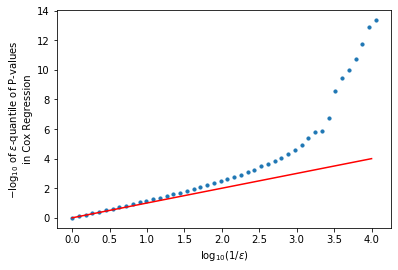

In [46]:
epsilon = np.logspace(-np.log10(cox.shape[0]-4),0,50,endpoint=True)[::-1] # 1 -> 1e-5
plt.scatter(-np.log10(epsilon), [-np.log10(cox.P.quantile(e)) for e in epsilon],s=10)
plt.plot([0,4],[0,4],c="red")
plt.ylabel("$-\\log_{10}$ of $\\epsilon$-quantile of P-values\nin Cox Regression")
plt.xlabel("$\\log_{10}(1/\\epsilon)$")

## Compare betas and lambdas

In [47]:
comp = pd.merge(cox, gwas_results[["SNP"]], left_on="SNP",right_on="SNP")
#comp = comp.loc[~comp.SNP.isin(["rs3819288"])] # Remove HLA-B

In [48]:
pearson_rho = lambda x : pearsonr(x["BETA"],x["lambda"])[0]
pearson_p = lambda x : pearsonr(x["BETA"],x["lambda"])[1]
spearman_rho = lambda x : spearmanr(x["BETA"],x["lambda"])[0]
spearman_p   = lambda x : spearmanr(x["BETA"],x["lambda"])[1]

In [49]:
threshold_code = 0.05/n_indep_codes
print(threshold_code)

9.523809523809524e-05


In [50]:
good_codes = comp.loc[comp.P < threshold_code].code.unique().tolist()

In [51]:
from scipy.stats import spearmanr
gb = comp.loc[comp.code.isin(good_codes)].groupby("code")
corr_by_code = gb.agg({"desc":"first"})
corr_by_code["pearson_rho"] = gb.apply(pearson_rho)
corr_by_code["pearson_p"]   = gb.apply(pearson_p)

In [52]:
corr_by_code.loc[corr_by_code["pearson_p"] < 0.05/n_indep_codes]

,desc,pearson_rho,pearson_p
code,,,


In [53]:
corr_by_code.sort_values("pearson_p")

,desc,pearson_rho,pearson_p
code,,,
E10.9,E10.9 Without complications,0.409390,0.065342
T43,"T43 Poisoning by psychotropic drugs, not elsew...",-0.373203,0.095645
E10,E10 Insulin-dependent diabetes mellitus,0.317078,0.161362
I26,I26 Pulmonary embolism,-0.290438,0.201532
I26.9,I26.9 Pulmonary embolism without mention of ac...,-0.284790,0.210837
K57,K57 Diverticular disease of intestine,0.266966,0.242056
I21,I21 Acute myocardial infarction,-0.266866,0.242239
K90,K90 Intestinal malabsorption,-0.205296,0.371996
Z86.7,Z86.7 Personal history of diseases of the circ...,-0.195961,0.394594


### Compare rho coeff between coag_codes and others

In [54]:
# remove primary-secondary duplicates
from scipy.stats import ttest_ind
indep_codes = corr_by_code.reset_index()["code"].str.split(".",expand=True)[0].unique().tolist()
corr_by_code_indep = corr_by_code.loc[corr_by_code.index.isin(indep_codes)]
coag_codes = ["I26","I21","Z86","H40","I10","I25","I63","I80"]

In [55]:
ttest_ind(corr_by_code_indep.loc[ corr_by_code_indep.index.isin(coag_codes),"pearson_rho"],
          corr_by_code_indep.loc[~corr_by_code_indep.index.isin(coag_codes),"pearson_rho"])

Ttest_indResult(statistic=-2.5492255155574606, pvalue=0.019108407605152377)

## Stratify by n

(array([6886., 5588., 4158., 3410., 2024., 1914., 1276.,  572.,  198.,
          88.]),
 array([3.00043408, 3.20515865, 3.40988321, 3.61460778, 3.81933235,
        4.02405692, 4.22878149, 4.43350606, 4.63823062, 4.84295519,
        5.04767976]),
 <a list of 10 Patch objects>)

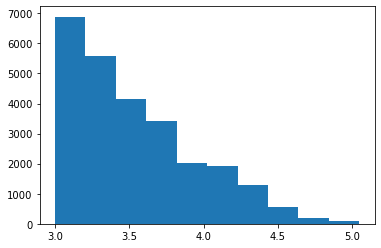

In [56]:
plt.hist(np.log10(cox.n))

In [57]:
cox["strata"] = np.digitize(cox.n,np.quantile(cox.n,[0.,.25,.5,.75]))

In [58]:
cox["first_letter"] = cox["code"].str[0]

In [59]:
cox.loc[cox.good].sort_values(["SYMBOL","P"])

,HR,P,code,covars,desc,n,SNP,lambda,SYMBOL,BETA,significant_all,significant_1,good,strata,first_letter
18154,1.017314,2.878190e-05,Z88,none,"Z88 Personal history of allergy to drugs, medi...",58086,rs78909033,0.017166,ANKMY1,0.069758,False,True,True,4,Z
1699,1.050216,1.710029e-06,C44.3,none,C44.3 Skin of other and unspecified parts of face,9623,rs1354034,0.048996,ARHGEF3,0.074894,True,True,True,4,C
10939,1.028904,1.502925e-05,C44,none,C44 Other malignant neoplasms of skin,23167,rs1354034,0.028494,ARHGEF3,0.074894,False,True,True,4,C
8490,1.056761,1.567598e-05,I80,none,I80 Phlebitis and thrombophlebitis,6408,rs1654425,0.055208,GP6,-0.091918,False,True,True,4,I
16058,1.042247,2.122289e-05,R79.8,none,R79.8 Other specified abnormal findings of blo...,10916,rs1654425,0.041379,GP6,-0.091918,False,True,True,4,R
25452,1.053470,2.692011e-05,I26.9,none,I26.9 Pulmonary embolism without mention of ac...,6792,rs1654425,0.052089,GP6,-0.091918,False,True,True,4,I
6444,1.040126,2.844824e-05,R79,none,R79 Other abnormal findings of blood chemistry,11682,rs1654425,0.039342,GP6,-0.091918,False,True,True,4,R
7830,1.051541,4.164343e-05,I26,none,I26 Pulmonary embolism,6942,rs1654425,0.050257,GP6,-0.091918,False,True,True,4,I
7822,1.075828,2.410441e-10,I26,none,I26 Pulmonary embolism,6942,rs10886430,0.073090,GRK5,-0.068886,True,True,True,4,I
25444,1.075604,4.224140e-10,I26.9,none,I26.9 Pulmonary embolism without mention of ac...,6792,rs10886430,0.072882,GRK5,-0.068886,True,True,True,4,I


In [60]:
cox.loc[cox.SNP == "TOTAL"].sort_values("P").head(20)

,HR,P,code,covars,desc,n,SNP,lambda,SYMBOL,BETA,significant_all,significant_1,good,strata,first_letter
11725,0.905814,0.000088,M72.04,none,M72.04 Palmar fascial fibromatosis [Dupuytren]...,1573,TOTAL,-0.098922,NaN,NaN,False,True,False,2,M
4047,1.098359,0.000115,T43,none,"T43 Poisoning by psychotropic drugs, not elsew...",1687,TOTAL,0.093817,NaN,NaN,False,False,False,2,T
3849,0.953452,0.000167,M72,none,M72 Fibroblastic disorders,6228,TOTAL,-0.047667,NaN,NaN,False,False,False,4,M
17643,0.974858,0.000440,K22,none,K22 Other diseases of oesophagus,19035,TOTAL,-0.025464,NaN,NaN,False,False,False,4,K
8601,0.940462,0.000475,B95.6,none,B95.6 Staphylococcus aureus as the cause of di...,3244,TOTAL,-0.061384,NaN,NaN,False,False,False,3,B
6929,1.075351,0.000623,D69.6,none,"D69.6 Thrombocytopenia, unspecified",2207,TOTAL,0.072647,NaN,NaN,False,False,False,2,D
19007,0.925382,0.000801,C44.1,none,"C44.1 Skin of eyelid, including canthus",1870,TOTAL,-0.077548,NaN,NaN,False,False,False,2,C
6423,0.913151,0.000805,M71,none,M71 Other bursopathies,1362,TOTAL,-0.090854,NaN,NaN,False,False,False,1,M
10779,1.083202,0.001189,G57.6,none,G57.6 Lesion of plantar nerve,1642,TOTAL,0.079921,NaN,NaN,False,False,False,2,G
18875,0.956073,0.001658,E10,none,E10 Insulin-dependent diabetes mellitus,4904,TOTAL,-0.044921,NaN,NaN,False,False,False,3,E


In [63]:
PT = cox.pivot_table(values=["significant_all"],aggfunc="mean",columns="strata",index="first_letter")
avg = cox.groupby("first_letter")[["significant_all"]].mean()
PT = pd.merge(PT,avg, left_index=True,right_index=True)

/home/hv270/.local/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [64]:
PT.head(3)

,"(significant_all, 1)","(significant_all, 2)","(significant_all, 3)","(significant_all, 4)",significant_all
first_letter,,,,,
A,0.0,0.0,0.0,0.000000,0.000000
B,0.0,0.0,0.0,0.000000,0.000000
C,0.0,0.0,0.0,0.004545,0.000812


In [65]:
cox.code.nunique()

1187

In [66]:
cox.SNP.unique()

array(['rs12566888', 'rs1434282', 'rs41315846', 'rs13412535',
       'rs78909033', 'rs1354034', 'rs13067286', 'rs76445378', 'rs922140',
       'rs3819288', 'rs55665228', 'rs61751937', 'rs10886430', 'rs7123827',
       'rs11553699', 'rs61978213', 'rs59001897', 'rs8057254',
       'rs12445050', 'rs11078475', 'rs1654425', 'TOTAL'], dtype=object)

Text(0.5, 0, 'first letter of ICD10 code')

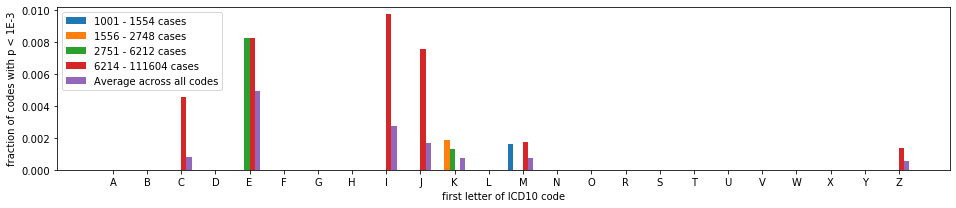

In [67]:
plt.figure(figsize=(16,3))
for i,c in enumerate(PT):
    #plt.bar(np.arange(PT.shape[0])+.15*(i-2),-np.log10(PT[c]),width=.15)
    try:
        label = "%d - %d cases" % (cox.loc[cox.strata == c[1],"n"].min(), cox.loc[cox.strata == c[1],"n"].max())
    except:
        label = "Average across all codes"
    plt.bar(np.arange(PT.shape[0])+.15*(i-PT.shape[1]/2.),PT[c],width=.15,label=label)
plt.xticks(np.arange(PT.shape[0]),PT.index)
plt.legend();
plt.ylabel("fraction of codes with p < 1E-3")
plt.xlabel("first letter of ICD10 code")

# Plot

In [33]:
from lifelines import KaplanMeierFitter

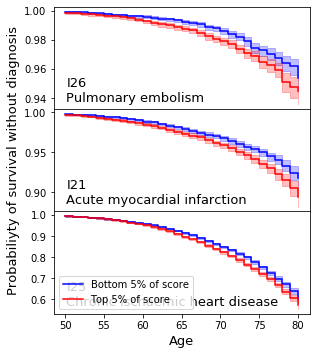

In [64]:
fig = plt.figure(figsize=(4.5,6))
gs = fig.add_gridspec(nrows=4,ncols=1,hspace=0.)

for i, code in enumerate(["I26","I21","I25"]):
    
    ax = fig.add_subplot(gs[i,0])
    
    events = all_ICD10_events.loc[all_ICD10_events.code == code]
    
    X_ = pd.merge(X[[BIRTH_FIELD,SEX_FIELD, DIABETES_FIELD,"AGE","SMOKING_RATE_bin","CHOLESTEROL_bin"] + list(set(all_basics_ + pc_covars_cols + pheno_cols))],events,left_index=True,right_on="ID",how="left").copy()
    X_["T"] = X_["AGE"].copy().astype(int)
    X_.loc[~X_.AGE_AT_EVENT.isnull(),"T"] = X_.loc[~X_.AGE_AT_EVENT.isnull(),"AGE_AT_EVENT"].astype(int)
    #X_.loc[~X_.AGE_AT_EVENT.isnull(),"T"] = X_.loc[~X_.AGE_AT_EVENT.isnull(),"AGE_AT_EVENT"]
    X_["EVENT"] = ~X_.AGE_AT_EVENT.isnull()*1
    X_ = X_.loc[X_["T"] >= 30]
    assert X_["T"].isnull().sum() == 0
    
    a = 0.05
    low = X_["best_pval_score_homogenous"] < X_["best_pval_score_homogenous"].quantile(a)
    high = X_["best_pval_score_homogenous"] > X_["best_pval_score_homogenous"].quantile(1-a)
    
    kmf_low = KaplanMeierFitter()
    kmf_low.fit(X_.loc[low,"T"],X_.loc[low,"EVENT"])
    kmf_low.plot_survival_function(loc=slice(50.,80.),label="Bottom %d%% of score" % int(100*a),legend=False,color="blue")

    kmf_high = KaplanMeierFitter()
    kmf_high.fit(X_.loc[high,"T"],X_.loc[high,"EVENT"])
    kmf_high.plot_survival_function(loc=slice(50.,80.),label="Top %d%% of score" % int(100*a),legend=False,color="red")
    
    if i == 2:
        plt.xlabel("Age",fontsize=13)
    elif i == 1:
        plt.ylabel("Probabiliyty of survival without diagnosis",fontsize=13)
    else:
        plt.xticks([])
        plt.xlabel(None)
    plt.title(None)
    plt.text(x=0.05,y=0.08,s="%s\n%s" % (code,ICD10_sec_desc[code][4:]),transform = ax.transAxes,fontsize=13)
plt.tight_layout()
plt.savefig("/home/hv270/sysmex2pf/figures/survival.pdf")
plt.legend()
plt.savefig("/home/hv270/sysmex2pf/figures/survival_legend.pdf")

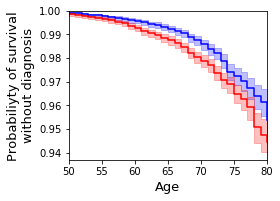

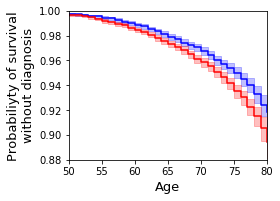

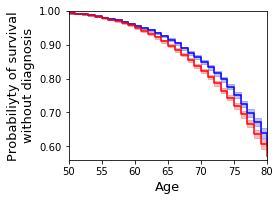

In [114]:
f = [0.063,0.12,0.44]
aspect_ratio = 3./4
import matplotlib.ticker as mtick
for i, code in enumerate(["I26","I21","I25"]):
    
    fig, ax = plt.subplots(figsize=(4.,4.))
    
    events = all_ICD10_events.loc[all_ICD10_events.code == code]
    
    X_ = pd.merge(X[[BIRTH_FIELD,SEX_FIELD, DIABETES_FIELD,"AGE","SMOKING_RATE_bin","CHOLESTEROL_bin"] + list(set(all_basics_ + pc_covars_cols + pheno_cols))],events,left_index=True,right_on="ID",how="left").copy()
    X_["T"] = X_["AGE"].copy().astype(int)
    X_.loc[~X_.AGE_AT_EVENT.isnull(),"T"] = X_.loc[~X_.AGE_AT_EVENT.isnull(),"AGE_AT_EVENT"].astype(int)
    #X_.loc[~X_.AGE_AT_EVENT.isnull(),"T"] = X_.loc[~X_.AGE_AT_EVENT.isnull(),"AGE_AT_EVENT"]
    X_["EVENT"] = ~X_.AGE_AT_EVENT.isnull()*1
    X_ = X_.loc[X_["T"] >= 30]
    assert X_["T"].isnull().sum() == 0
    ax.set_aspect(aspect_ratio*30/f[i])
    ax.set_ylim((1-f[i],1.))
    ax.set_xlim((50,80))
    
    a = 0.05
    low = X_["best_pval_score_homogenous"] < X_["best_pval_score_homogenous"].quantile(a)
    high = X_["best_pval_score_homogenous"] > X_["best_pval_score_homogenous"].quantile(1-a)
    
    kmf_low = KaplanMeierFitter()
    kmf_low.fit(X_.loc[low,"T"],X_.loc[low,"EVENT"])
    kmf_low.plot_survival_function(loc=slice(50.,80.),label="Bottom %d%% of score" % int(100*a),legend=False,color="blue")

    kmf_high = KaplanMeierFitter()
    kmf_high.fit(X_.loc[high,"T"],X_.loc[high,"EVENT"])
    kmf_high.plot_survival_function(loc=slice(50.,80.),label="Top %d%% of score" % int(100*a),legend=False,color="red")
    
    plt.xlabel("Age",fontsize=13)
    plt.ylabel("Probabiliyty of survival\nwithout diagnosis",fontsize=13)
    
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    
    #plt.title(ICD10_sec_desc[code])
    #plt.text(x=0.05,y=0.08,s=ICD10_sec_desc[code],transform = ax.transAxes,fontsize=13)
    plt.tight_layout()
    plt.savefig("/home/hv270/sysmex2pf/figures/survival_%s.pdf" % code)
    #plt.legend()
    #plt.savefig("/home/hv270/sysmex2pf/figures/survival_%s_legend.pdf" % code)

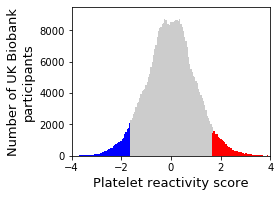

In [118]:
bins = np.linspace(-4,4,int(8/0.05))
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
y_max = 9500
ax.set_ylim((0,y_max))
ax.set_aspect(aspect_ratio*8/y_max)
ax.set_xlim((-4,4))
plt.hist(X_["best_pval_score_homogenous"],bins=bins,color="gray",alpha=.4);
plt.hist(X_.loc[low,"best_pval_score_homogenous"],bins=bins,color="blue",alpha=1);
plt.hist(X_.loc[high,"best_pval_score_homogenous"],bins=bins,color="red",alpha=1);
plt.xlabel("Platelet reactivity score",fontsize=13)
plt.ylabel("Number of UK Biobank\nparticipants",fontsize=13)
plt.tight_layout()
plt.savefig("/home/hv270/sysmex2pf/figures/score_hist.pdf")

# Unused

In [64]:
gwas_results = pd.read_csv("/home/hv270/sysmex2pf/GWAS_table.csv",index_col=0)

In [65]:
cox_and_GWAS = pd.merge(cox, gwas_results,left_on="SNP",right_on="SNP",how="left",suffixes=("_Cox","_GWAS"))\
    .rename(columns={"HR":"Hazard Ratio",
                     "corars":"Covariates used in Cox Regression",
                     "strata":"quartile (of # of cases)"})
cox_and_GWAS.to_csv("/home/hv270/sysmex2pf/GWAS_and_Cox.csv")

In [66]:
per_SNP = cox.sort_values("P").groupby("SNP").first().sort_values("P")

In [67]:
gwas_results.head(3)

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,F_MISS,BETA,SE,...,CLIN_SIG,SOMATIC,PHENO,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,TRANSCRIPTION_FACTORS,was_in_NY_GWAS
0,rs12566888,1,156869047,0,G,T,0.909454,0.003681,0.124848,0.012357,...,-,-,1,"29865896,20526338,27641736,28002340,29407631,2...",-,-,-,-,-,True
1,rs1434282,1,199010721,0,C,T,0.264595,0.066475,0.069782,0.008351,...,-,-,1,"27863252,29403010,30595370,32888493",-,-,-,-,-,False
2,rs41315846,1,247712303,0,T,C,0.526638,0.095375,0.052608,0.007460,...,-,"0,0,1","1,1,1","27668658,27863252",-,-,-,-,-,False


In [117]:
per_SNP = pd.merge(per_SNP,
         gwas_results[["SNP","CHR","BP","A1FREQ","was_in_NY_GWAS","PUBMED","SYMBOL","BETA"]],
         left_index=True,right_on="SNP",how="left")
per_SNP["isin_PUBMED"] = per_SNP.PUBMED != "-"

In [120]:
per_SNP_export = per_SNP[["SNP","SYMBOL","P","desc","HR","BETA","covars","was_in_NY_GWAS","isin_PUBMED"]]\
    .rename(columns={"SYMBOL":"GENE (VEP selected)",
                     "P":"lowest P-value (Cox Regression)",
                     "HR":"hazard ratio",
                     "covars":"Covariates used"})

In [121]:
per_SNP_export.to_csv("/home/hv270/sysmex2pf/cox_and_GWAS.csv")

In [57]:
p = Pool(15)

for lt in tqdm(p.imap_unordered(compare_top_bottom, all_ICD10_events.groupby("code")),
              total=all_ICD10_events.code.nunique()):
    if lt is None: continue
    lt, desc = lt
    p_val = lt.summary["p"].iloc[0]
    if p_val < 1e-3:
        print(desc)
        print(lt.summary)
p.close()
p.join()

100%|██████████| 12222/12222 [01:09<00:00, 175.89it/s]


# Logistic regression

In [160]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [162]:
from sklearn.linear_model import LogisticRegression
from statsmodels.api import GLM
from statsmodels.genmod import families

In [138]:
for c in codes_to_focus_on:
    X[c] = X.index.isin(all_ICD10_events.loc[all_ICD10_events.code == c].ID.unique().tolist())

In [171]:
X["anti_coag"] *= 1

In [175]:
h1_cols = ["TOTAL_PFC","AGE"] #["AGE","thrombotic_event"]
h0_cols = ["AGE"] # ,"thrombotic_event"

for c in codes_to_focus_on:
    print(c)
    lr_just_score = GLM(X[c],X[["TOTAL_PFC","AGE"]], family=families.Binomial()).fit(attach_wls=True, atol=1e-10)
    print(lr_just_score.summary())
    lr_thrombotic = GLM(X[c],X[["TOTAL_PFC","AGE","thrombotic_event"]], family=families.Binomial()).fit(attach_wls=True, atol=1e-10)
    print(lr_thrombotic.summary())
    lr_anticoag = GLM(X[c],X[["TOTAL_PFC","AGE","anti_coag"]], family=families.Binomial()).fit(attach_wls=True, atol=1e-10)
    print(lr_anticoag.summary())
    lr_anticoag = GLM(X[c],X[["TOTAL_PFC","AGE","anti_coag","thrombotic_event"]], family=families.Binomial()).fit(attach_wls=True, atol=1e-10)
    print(lr_anticoag.summary())

D69
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    D69   No. Observations:               384059
Model:                            GLM   Df Residuals:                   384057
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17891.
Date:                Wed, 16 Feb 2022   Deviance:                       35783.
Time:                        17:01:04   Pearson chi2:                 5.64e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
TOTAL_PFC      0.0703      0.018      3.972     

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  D69.6   No. Observations:               384059
Model:                            GLM   Df Residuals:                   384056
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13960.
Date:                Wed, 16 Feb 2022   Deviance:                       27920.
Time:                        17:01:07   Pearson chi2:                 5.76e+05
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
TOTAL_PFC      0.0934      0.020      4.624      0.0

In [156]:
lr.coef_

array([[0.1052082, 0.0403093]])

In [157]:
lr_null.coef_

array([[0.04030834]])

# Simple Linear Regression

In [176]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [208]:
def do_linear_test(args, phenos):
    
    code, events = args
    n_cases = events.shape[0]
    desc = ICD10_sec_desc["".join(code.split("."))]
    if n_cases <= min_n_cases: return None
    # get T column
    X_ = pd.merge(X[[BIRTH_FIELD,SEX_FIELD, DIABETES_FIELD,"AGE"] + list(set(all_basics_ + pc_covars_cols + pheno_cols))],events,left_index=True,right_on="ID",how="left").copy()
    X_["T"] = X_["AGE"].copy().astype(int)
    X_.loc[~X_.AGE_AT_EVENT.isnull(),"T"] = X_.loc[~X_.AGE_AT_EVENT.isnull(),"AGE_AT_EVENT"].astype(int)
    #X_.loc[~X_.AGE_AT_EVENT.isnull(),"T"] = X_.loc[~X_.AGE_AT_EVENT.isnull(),"AGE_AT_EVENT"]
    X_["EVENT"] = ~X_.AGE_AT_EVENT.isnull()*1
    assert X_["T"].isnull().sum() == 0
    
    #print(X_.loc[X_.EVENT > 0].head())
    
    #only_old_people = X_["T"] >= 18
    #if only_old_people.mean() < .6:
    #    print("Keeping %.2f for %s" % (only_old_people.mean(),desc))
    #X_ = X_.loc[only_old_people]
    
    
    # find if unisex
    n_cases = X_.EVENT.sum()
    valid_sexes = X_.loc[X_["EVENT"] > 0,SEX_FIELD].value_counts()
    valid_sexes = valid_sexes.loc[valid_sexes > (n_cases / 50)].index.tolist()
    unisex = len(valid_sexes) == 1
    if unisex:
        desc += " (unisex)"
    
    # Define people to include and strata
    to_include = X_[SEX_FIELD].isin(valid_sexes)
    strata = [SEX_FIELD] if not unisex else []
    strata += [DIABETES_FIELD]
        
    X_ = X_.loc[to_include]
    
    n_cases = X_.EVENT.sum()
    if n_cases <= min_n_cases: return None
    
    p_vals = []
    HRs = []
    c_group = []
    pheno = []
    
    cols_to_normalize = [c for c in X_.columns if X_[c].dtype == float and c != "EVENT"]
    cols_to_normalize += ["T","2443-0.0"]
    
    X_[cols_to_normalize] -= X_[cols_to_normalize].mean(axis=0)
    X_[cols_to_normalize] /= X_[cols_to_normalize].std(axis=0)
    
    for covars_group in basics_:
        basics = list(basics_[covars_group]) + ["T"]
        if not unisex:
            basics += [SEX_FIELD]
        

        cols_to_include_1 = basics #+ pc_covars_cols[:3]
        lm1 = LogisticRegression(penalty="none",solver="sag")
        lm1.fit(X_[cols_to_include_1],X_["EVENT"] > 0)
        
        LP = lm1.predict_log_proba(X_[cols_to_include_1])
        LL_without = np.sum(np.where(X_["EVENT"],LP[:,1],LP[:,0]))
        for s in phenos:
            cols_to_include_2 = cols_to_include_1 + [s]
            
            lm2 = LogisticRegression(penalty="none",solver="sag")
            lm2.fit(X_[cols_to_include_2], X_["EVENT"] > 0)

            LP = lm2.predict_log_proba(X_[cols_to_include_2])
            LL_with = np.sum(np.where(X_["EVENT"] > 0,LP[:,1],LP[:,0]))
            
            
            Delta_LL = LL_with-LL_without
            
            p_val = 1.-chi2(1).cdf(2*Delta_LL)

            ### cox_info.loc[code, "p"] = p_val
            HR = lm2.coef_[0,-1]
            ### cox_info.loc[code, "HR"] = HR
            
            p_vals.append(p_val)
            HRs.append(HR)
            c_group.append(covars_group)
            pheno.append(s)

            description = ""
            description += "| %s \t| %s : %.2f\t" % (s, covars_group,-np.log10(p_val))
            description += "%d cases \t %s \t %s" % (n_cases, code, desc)
            if p_val < 1e-3:
                print("==========================")
                print(description)
                print("==========================")
    
    return code, p_vals, n_cases, desc, HRs, c_group, pheno

In [209]:
basics_ = {#"none":[],
           #"sysmex":pc_covars_cols[:3],
           #"environmental":["SMOKING_RATE",BMI_FIELD,CHOLESTEROL_FIELD],
           "all":pc_covars_cols[:3] + ["SMOKING_RATE",BMI_FIELD,DIABETES_FIELD,CHOLESTEROL_FIELD]}

In [210]:
n_events = all_ICD10_events.code.value_counts()
large_events = n_events.loc[n_events >= min_n_cases].index.tolist()
cond = all_ICD10_events.code.isin(large_events)

In [ ]:
p = Pool(32)

codes_ = []
descs_ = []
n_cases_ = []
P_ = []
HR_ = []
phenos_ = []
covs_ = []

do_linear_test_pheno = partial(do_linear_test,phenos=pheno_cols)
for _ in tqdm(p.imap_unordered(do_linear_test_pheno, all_ICD10_events.loc[cond].groupby("code")),
              total=all_ICD10_events.loc[cond].code.nunique()):
    if _ is None: continue
    code, p_vals, n_cases, desc, HRs, covs, phenos = _
    for i in range(len(p_vals)):
        HR_.append(HRs[i])
        P_.append(p_vals[i])
        covs_.append(covs[i])
        codes_.append(code)
        descs_.append(desc)
        n_cases_.append(n_cases)
        phenos_.append(phenos[i])
p.close()
p.join()

  0%|          | 3/917 [00:08<35:56,  2.36s/it]  

| rs13067286 	| all : 3.17	1845 cases 	 C25.9 	 C25.9 Pancreas, unspecified


  8%|▊         | 76/917 [06:17<38:30,  2.75s/it]  

| rs3557 	| all : 3.13	2215 cases 	 E11.3 	 E11.3 With ophthalmic complications


 26%|██▋       | 242/917 [19:28<31:32,  2.80s/it]  

| rs10886430 	| all : 3.43	1735 cases 	 I69.4 	 I69.4 Sequelae of stroke, not specified as haemorrhage or infarction


 63%|██████▎   | 578/917 [41:50<16:28,  2.92s/it]  /home/hv270/platelets/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
 63%|██████▎   | 579/917 [41:52<14:15,  2.53s/it]/home/hv270/platelets/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/hv270/platelets/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
 64%|██████▎   | 583

| rs78909033 	| all : 3.10	8150 cases 	 Z88.6 	 Z88.6 Personal history of allergy to analgesic agent


 89%|████████▉ | 814/917 [58:43<06:59,  4.07s/it]

| rs35173808 	| all : 3.03	7216 cases 	 Z88.1 	 Z88.1 Personal history of allergy to other antibiotic agents


 92%|█████████▏| 840/917 [1:00:49<04:35,  3.57s/it]

| rs76445378 	| all : 3.04	13223 cases 	 Z96.1 	 Z96.1 Presence of intraocular lens


 94%|█████████▍| 862/917 [1:02:34<02:39,  2.90s/it]